# Analysis of NGC 3627 

In [193]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED
from XRBID.WriteScript import WriteReg

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, XrayBinary
from helpers.analysis import (calculate_distance, calculate_velocity)

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


I have performed XRBID identification with both [HST](https://github.com/devkhullar/querx/blob/main/galaxies/M66_corrected.ipynb) and [JWST](https://github.com/devkhullar/querx/blob/main/galaxies/M66_jwst.ipynb) on NGC 3627. Now, I am going to perform cluster analysis on the XRB sources within M66. This is the list of the tasks that are yet to be completed:
1. Merge JWST and HST work
    1. Figure out the compact association catalog to use.
2. Perform Cluster analysis 
    1. Find the most likely parent cluster or compact association for each X-ray source.
    2. Distance Plots
    3. Minimum Velocity Plots
    4. Escape Velocity Plots
3. Maximum Velocity
    1. Write Algorithm for finding the maximum velocity
4. Make M/R velocity plots (look out for differences in LMXBs and HMXBs)
5. XRB Lx vs Distance Plots and XRB Lx vs Velocity (using min-max velocities as errorbars)

# Merge HST and JWST work

As for combining HST+JWST, here's how I would do it: <br>
(1) You already have some DataFrames that cross-references the stars of each XRB in HST and JWST. If you haven't already, pull their photometries. You should use these to build a single DataFrame containing each XRB, all stars associated with each XRB, and their magnitudes in each filter. <br>
(2) You also have a DataFrame containing 2sig JWST stars that don't have HST counterparts. Get the photometries and concatenate it to the  DataFrame in (1). All of the HST headers should be empty for these stars, which is okay! The DataFrame should now include every XRB and every star associated with each XRB observed by HST, JWST, or both. <br>
(3) Create a new header to give each star a unique ID (like NGC3627-X01-S01 or something). You can now run this entire DataFrame through fitSED (using the acs+nircam or wfc3+nircam setting as the instrument and the new header as idheader). This should give you the best fit mass and age of each star associated with each XRB. <br>
(4) I would probably add back in the XRB IDs to the best fit model DataFrame. That way you can run Find on to pull the info for each XRB to get a range of masses and ages associated with it, which you can use to decide which cluster your XRB is most likely associated with. <br>
Let me know if you have questions! Also, if you think of a better way to do this, feel free to implement it. <br>

In [176]:
# 1. The mutual sources in HST and JWST 
# These sources contain
M66_xrbs = remove_unnamed(pd.read_csv(M66_dir+'M66_XRBs_hst_jwst_mutual_daoclean_sources.csv'))
# Rename columns to make it FitSED compatible
M66_xrbs = M66_xrbs.rename(columns={
    'F200W ID' : 'F2000W ID',
    'F300M ID' : 'F3000M ID',
    'F335M ID' : 'F3350M ID',
    'F360M ID' : 'F3600M ID'
})

# Rearrange columns for a better, readable format
columns = [ 'CSC ID', 'RA', 'Dec', 'JWST ID', 'HST ID', 'F2000W ID', 'F3000M ID', 'F3350M ID',
       'F3600M ID', 'F275W ID', 'F336W ID', 'F438W ID',
       'F555W ID', 'F814W ID', 'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err',
       'F3350M', 'F3350M Err', 'F3600M', 'F3600M Err', 'F275W', 'F275W Err',
       'F336W', 'F336W Err', 'F438W', 'F438W Err', 'F555W', 'F555W Err',
       'F814W', 'F814W Err']

M66_xrbs = M66_xrbs[columns]
# Add the XRB classification to the dataframe
# Add the source classification to this catalog
M66_notes = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"))
temp = M66_notes[['CSC ID', 'Class']]

# Merge with the main dataframe and only use HMXB classifications
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')
M66_xrbs = Find(M66_xrbs, 'Class = HMXB')
display(M66_xrbs)

CSC ID          RA        Dec  JWST ID  HST ID  F2000W ID  \
0   2CXO J112014.9+125933  170.062313  12.992598        1       2     194701   
1   2CXO J112014.9+125933  170.062307  12.992623        3       2     194908   
2   2CXO J112014.9+125933  170.062255  12.992622        4       2     194909   
3   2CXO J112015.0+125936  170.062808  12.993437        2       1     200852   
4   2CXO J112015.0+125936  170.062752  12.993454        3       1     201035   
..                    ...         ...        ...      ...     ...        ...   
77  2CXO J112019.0+130027  170.079682  13.007607       17       3     297917   
78  2CXO J112019.0+130027  170.079682  13.007607       17       4     297917   
79  2CXO J112019.0+130027  170.079491  13.007663       19       6     298214   
80  2CXO J112019.0+130027  170.079599  13.007786       23       7     298884   
81  2CXO J112013.0+125736  170.054191  12.960178        4       1      26519   

    F3000M ID  F3350M ID  F3600M ID  F275W ID  ...  F275W Err     F336W  \
0     45185.0        NaN        NaN  130956.0  ...  -1.372681       NaN   
1     45185.0        NaN        NaN  130956.0  ...  -1.372681       NaN   
2         NaN        NaN        NaN  130956.0  ...  -1.372681       NaN   
3     46417.0    42593.0    48557.0       NaN  ...        NaN       NaN   
4     46417.0    42593.0        NaN       NaN  ...        NaN       NaN   
..        ...        ...        ...       ...  ...        ...       ...   
77    67859.0        NaN        NaN       NaN  ...        NaN -6.692719   
78    67859.0        NaN        NaN       NaN  ...        NaN -6.997950   
79        NaN    62954.0    71040.0       NaN  ...        NaN -6.580109   
80        NaN        NaN        NaN       NaN  ...        NaN       NaN   
81     6497.0     5610.0     6873.0   48203.0  ...  -0.067507       NaN   

    F336W Err     F438W  F438W Err     F555W  F555W Err     F814W  F814W Err  \
0         NaN -7.711479  -0.896442 -8.481385  -0.973168       NaN        NaN   
1         NaN -7.711479  -0.896442 -8.481385  -0.973168       NaN        NaN   
2         NaN -7.711479  -0.896442 -8.481385  -0.973168       NaN        NaN   
3         NaN       NaN   1.142291       NaN   1.536468       NaN        NaN   
4         NaN       NaN   1.142291       NaN   1.536468       NaN        NaN   
..        ...       ...        ...       ...        ...       ...        ...   
77  -0.039173 -5.665787  -0.068720 -5.744792  -0.088761       NaN        NaN   
78  -0.031641 -5.861237  -0.058837 -5.843920  -0.082088       NaN        NaN   
79  -0.039355       NaN        NaN -5.415056  -0.115540       NaN        NaN   
80        NaN -5.181509  -0.107074 -5.471582  -0.111046       NaN        NaN   
81        NaN       NaN        NaN -4.666819  -0.496001 -6.341185   -0.40756   

    Class  
0    HMXB  
1    HMXB  
2    HMXB  
3    HMXB  
4    HMXB  
..    ...  
77   HMXB  
78   HMXB  
79   HMXB  
80   HMXB  
81   HMXB  

[82 rows x 33 columns]

In my XRB catalog, there are about 18 XRBs. I need to compare `hmxbs_unique` with the `M66_jwst_hmxbs` dataframe to see which elements are missing

'2CXO J112011.8+125811', '2CXO J112015.9+125727' are not in the photometry dataframe so I need to add them manually. I will also flag them, just in case if need to look into them later. 

In [177]:
# JWST HMXBs photometry
M66_jwst_hmxbs = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_hmxbs_photometry_jwst.csv"))
M66_hst_hmxbs = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_hmxbs_photometry.csv"))
hmxbs_unique = FindUnique(M66_xrbs, ['Class == HMXB'],header='CSC ID')
x, y = set(hmxbs_unique['CSC ID'].values), set(M66_jwst_hmxbs['CSC ID'].values)
x ^ y

{'2CXO J112011.8+125811', '2CXO J112015.9+125727'}

In [178]:
# Change column names in JWST dataframes
columns={
    'F200W ID'    : 'F2000W ID',
    'F300M ID'    : 'F3000M ID',
    'F335M ID'    : 'F3350M ID',
    'F360M ID'    : 'F3600M ID',
    'F200W'       : 'F2000W',
    'F3000M'      : 'F3000M',
    'F335M'       : 'F3350M',
    'F360M'       : 'F3600M',
    'F200W Err'   : 'F2000W Err',
    'F300M Err'   : 'F3000M Err',
    'F335M Err'   : 'F3350M Err',
    'F3600M Err'  : 'F3600M Err',
    'StarID'      : 'JWST ID'
}
M66_jwst_hmxbs = M66_jwst_hmxbs.rename(columns=columns)
M66_hst_hmxbs = M66_hst_hmxbs.rename(columns={'ID': 'HST ID'})

# Use the columns with the required CSC IDs
jwst_temp = M66_jwst_hmxbs.query('`CSC ID` == "2CXO J112011.8+125811" or `CSC ID` == "2CXO J112015.9+125727"').reset_index(drop=True).copy()
hst_temp = M66_hst_hmxbs.query('`CSC ID` == "2CXO J112011.8+125811" or `CSC ID` == "2CXO J112015.9+125727"').reset_index(drop=True).copy()

# Merge the two dfs with the sources in JWST and HST that did not match
hst_temp = hst_temp[['CSC ID', 'HST ID', 'F555W ID', 'F275W ID', 'F336W ID',
                     'F438W ID', 'F814W ID', 'F555W', 'F555W Err', 'F438W',
                     'F438W Err', 'F814W', 'F814W Err', 'F275W', 'F275W Err',
                    'F336W', 'F336W Err']]
# Since the sources did not match in JWST, as a work around
# I am using the RA and Dec coordinates of JWST 
temp = jwst_temp.merge(hst_temp, on='CSC ID', how='left')
temp['Flag'] = 'True'
temp['Notes'] = "The HST and JWST sources did not crossref"

# Concatenating the JWST and HST work into the M66_xrbs dataframe
M66_xrbs = pd.concat([M66_xrbs, temp])
M66_xrbs

CSC ID          RA        Dec  JWST ID  HST ID  F2000W ID  \
0   2CXO J112014.9+125933  170.062313  12.992598        1       2     194701   
1   2CXO J112014.9+125933  170.062307  12.992623        3       2     194908   
2   2CXO J112014.9+125933  170.062255  12.992622        4       2     194909   
3   2CXO J112015.0+125936  170.062808  12.993437        2       1     200852   
4   2CXO J112015.0+125936  170.062752  12.993454        3       1     201035   
..                    ...         ...        ...      ...     ...        ...   
79  2CXO J112019.0+130027  170.079491  13.007663       19       6     298214   
80  2CXO J112019.0+130027  170.079599  13.007786       23       7     298884   
81  2CXO J112013.0+125736  170.054191  12.960178        4       1      26519   
0   2CXO J112011.8+125811  170.049502  12.969909        5       1      58631   
1   2CXO J112015.9+125727  170.066405  12.957754        1       2      20630   

    F3000M ID  F3350M ID  F3600M ID  F275W ID  ...  F555W Err     F814W  \
0     45185.0        NaN        NaN  130956.0  ...  -0.973168       NaN   
1     45185.0        NaN        NaN  130956.0  ...  -0.973168       NaN   
2         NaN        NaN        NaN  130956.0  ...  -0.973168       NaN   
3     46417.0    42593.0    48557.0       NaN  ...   1.536468       NaN   
4     46417.0    42593.0        NaN       NaN  ...   1.536468       NaN   
..        ...        ...        ...       ...  ...        ...       ...   
79        NaN    62954.0    71040.0       NaN  ...  -0.115540       NaN   
80        NaN        NaN        NaN       NaN  ...  -0.111046       NaN   
81     6497.0     5610.0     6873.0   48203.0  ...  -0.496001 -6.341185   
0         NaN        NaN        NaN       NaN  ...  -0.285757 -6.476676   
1         NaN        NaN        NaN       NaN  ...  -0.055671       NaN   

    F814W Err  Class            X            Y  F300M  F360M Err  Flag  \
0         NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
1         NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
2         NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
3         NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
4         NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
..        ...    ...          ...          ...    ...        ...   ...   
79        NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
80        NaN   HMXB          NaN          NaN    NaN        NaN   NaN   
81  -0.407560   HMXB          NaN          NaN    NaN        NaN   NaN   
0   -0.443484    NaN  4567.264252  3248.497515    NaN        NaN  True   
1         NaN    NaN  2638.804107  1825.304918    NaN        NaN  True   

                                        Notes  
0                                         NaN  
1                                         NaN  
2                                         NaN  
3                                         NaN  
4                                         NaN  
..                                        ...  
79                                        NaN  
80                                        NaN  
81                                        NaN  
0   The HST and JWST sources did not crossref  
1   The HST and JWST sources did not crossref  

[84 rows x 39 columns]

In [179]:
# 2. Add DataFrame containing 2sig JWST stars that don't have HST 
# counterparts. Get the photometries and concatenate it to the
# DataFrame in (1). All of the HST headers should be empty for 
# these stars, which is okay! The DataFrame should now include 
# every XRB and every star associated with each XRB observed 
# by HST, JWST, or both

M66_lmxbs = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_lmxbs_photometry_jwst.csv"))
M66_lmxbs['Class'] = 'LMXB'
# rename column names to make them FitSED compatible
columns={
    'F200W ID'    : 'F2000W ID',
    'F300M ID'    : 'F3000M ID',
    'F335M ID'    : 'F3350M ID',
    'F360M ID'    : 'F3600M ID',
    'F200W'       : 'F2000W',
    'F3000M'      : 'F3000M',
    'F335M'       : 'F3350M',
    'F360M'       : 'F3600M',
    'F200W Err'   : 'F2000W Err',
    'F300M Err'   : 'F3000M Err',
    'F335M Err'   : 'F3350M Err',
    'F3600M Err'  : 'F3600M Err',
    'StarID'      : 'JWST ID'
}
M66_lmxbs = M66_lmxbs.rename(columns=columns)

# Concatenate this dataframe to M66_xrbs
M66_xrbs = pd.concat([M66_xrbs, M66_lmxbs]).reset_index(drop=True)
M66_xrbs

CSC ID          RA        Dec  JWST ID  HST ID  F2000W ID  \
0    2CXO J112014.9+125933  170.062313  12.992598        1     2.0     194701   
1    2CXO J112014.9+125933  170.062307  12.992623        3     2.0     194908   
2    2CXO J112014.9+125933  170.062255  12.992622        4     2.0     194909   
3    2CXO J112015.0+125936  170.062808  12.993437        2     1.0     200852   
4    2CXO J112015.0+125936  170.062752  12.993454        3     1.0     201035   
..                     ...         ...        ...      ...     ...        ...   
102  2CXO J112017.1+130025  170.071459  13.007163        3     NaN     295482   
103  2CXO J112016.4+130034  170.068549  13.009719       22     NaN     308544   
104  2CXO J112018.7+130027  170.078058  13.007556        1     NaN     297652   
105  2CXO J112017.5+125818  170.072952  12.971857        1     NaN      66103   
106  2CXO J112019.7+130030  170.082249  13.008335        5     NaN     301712   

     F3000M ID  F3350M ID  F3600M ID  F275W ID  ...  F555W Err  F814W  \
0      45185.0        NaN        NaN  130956.0  ...  -0.973168    NaN   
1      45185.0        NaN        NaN  130956.0  ...  -0.973168    NaN   
2          NaN        NaN        NaN  130956.0  ...  -0.973168    NaN   
3      46417.0    42593.0    48557.0       NaN  ...   1.536468    NaN   
4      46417.0    42593.0        NaN       NaN  ...   1.536468    NaN   
..         ...        ...        ...       ...  ...        ...    ...   
102        NaN        NaN        NaN       NaN  ...        NaN    NaN   
103        NaN        NaN        NaN       NaN  ...        NaN    NaN   
104        NaN        NaN        NaN       NaN  ...        NaN    NaN   
105    16342.0    14372.0    17297.0       NaN  ...        NaN    NaN   
106    68734.0    63775.0    71929.0       NaN  ...        NaN    NaN   

     F814W Err  Class            X            Y     F300M  F360M Err  Flag  \
0          NaN   HMXB          NaN          NaN       NaN        NaN   NaN   
1          NaN   HMXB          NaN          NaN       NaN        NaN   NaN   
2          NaN   HMXB          NaN          NaN       NaN        NaN   NaN   
3          NaN   HMXB          NaN          NaN       NaN        NaN   NaN   
4          NaN   HMXB          NaN          NaN       NaN        NaN   NaN   
..         ...    ...          ...          ...       ...        ...   ...   
102        NaN   LMXB  2062.230417  7610.007514       NaN        NaN   NaN   
103        NaN   LMXB  2394.086201  7909.223941       NaN        NaN   NaN   
104        NaN   LMXB  1309.443455  7655.963957       NaN        NaN   NaN   
105        NaN   LMXB  1891.868291  3476.508951 -9.589733  -0.338285   NaN   
106        NaN   LMXB   831.290481  7747.193740 -9.686687  -0.154806   NaN   

     Notes  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
..     ...  
102    NaN  
103    NaN  
104    NaN  
105    NaN  
106    NaN  

[107 rows x 39 columns]

In [296]:
from XRBID.WriteScript import WriteReg
WriteReg(
    sources=M66_xrbs,
    coordheads=['RA', 'Dec'],
    coordsys='fk5',
    idheader='HST ID',
    radius=0.07,
    radunit='arcsec',
    outfile='/Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg'
)

Saving /Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg
/Users/undergradstudent/Downloads/M66_mutual_sources_hst_jwst.reg saved!


In [180]:
# 3 and 4
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] +  "-" + M66_xrbs['JWST ID'].astype(str) \
                         + "-" + M66_xrbs['HST ID'].astype(str)

In [181]:
M66_xrbs.to_csv(M66_dir+'M66_hmxbs-hst_xrbs-jwst.csv')

Finding best-fit model(s)...
DONE


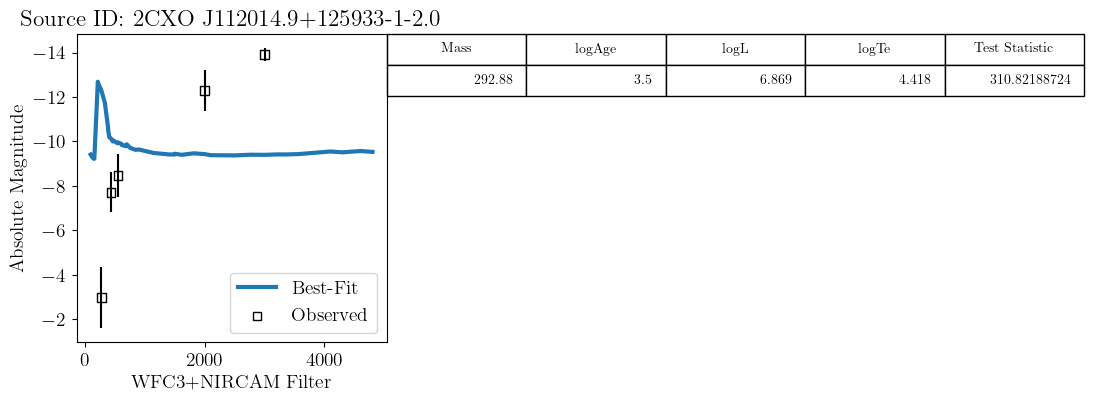

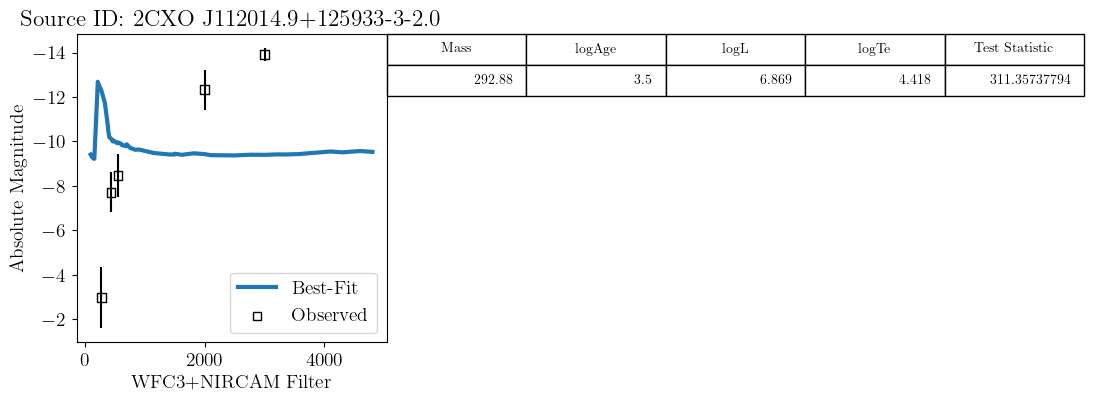

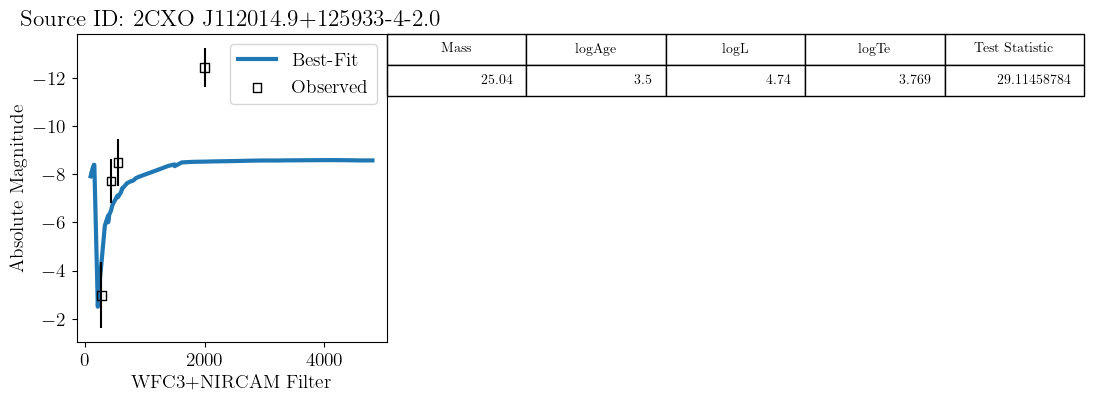

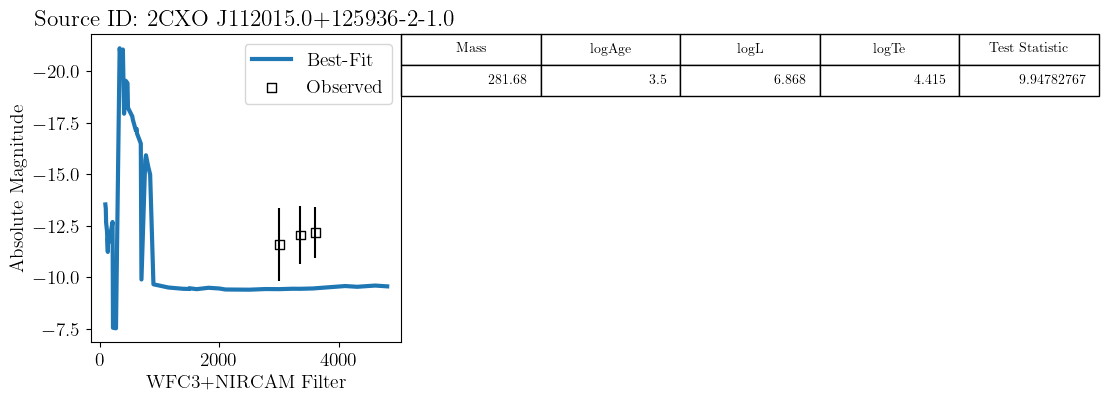

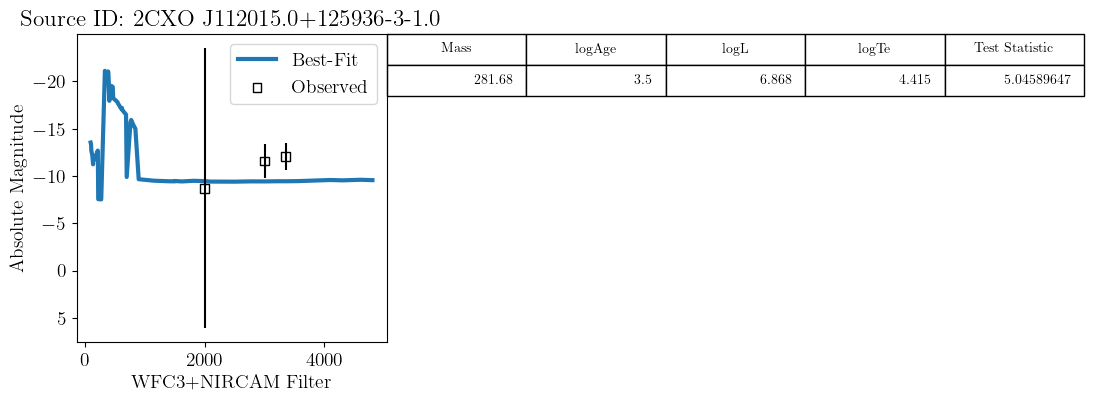

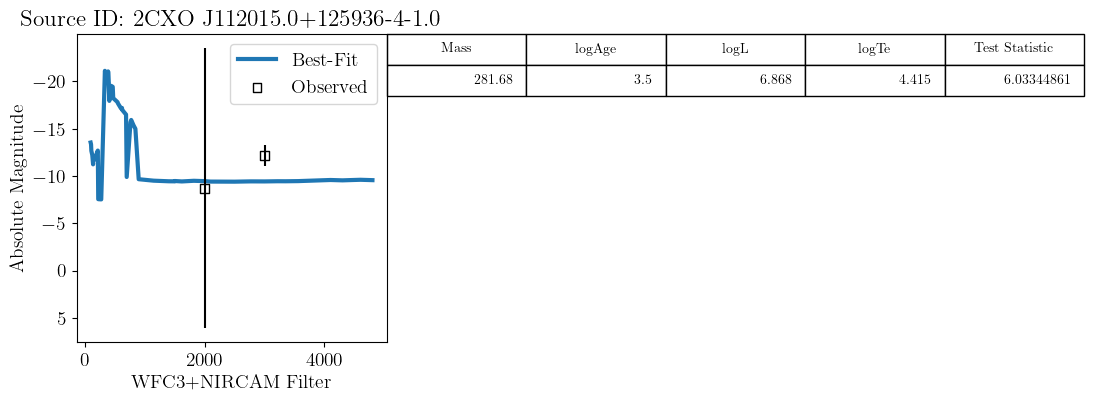

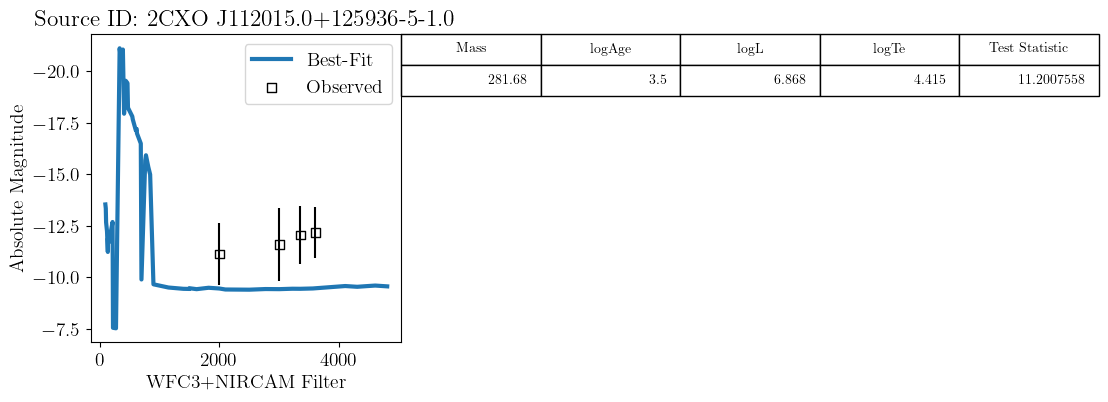

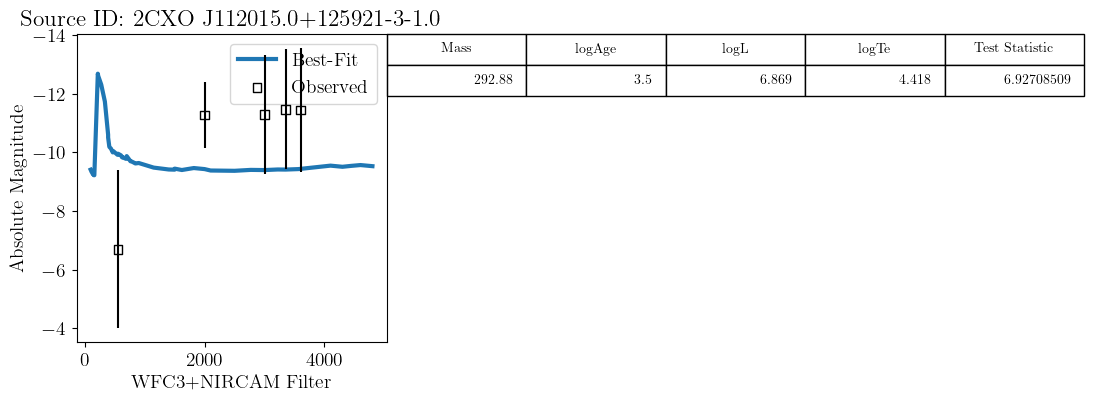

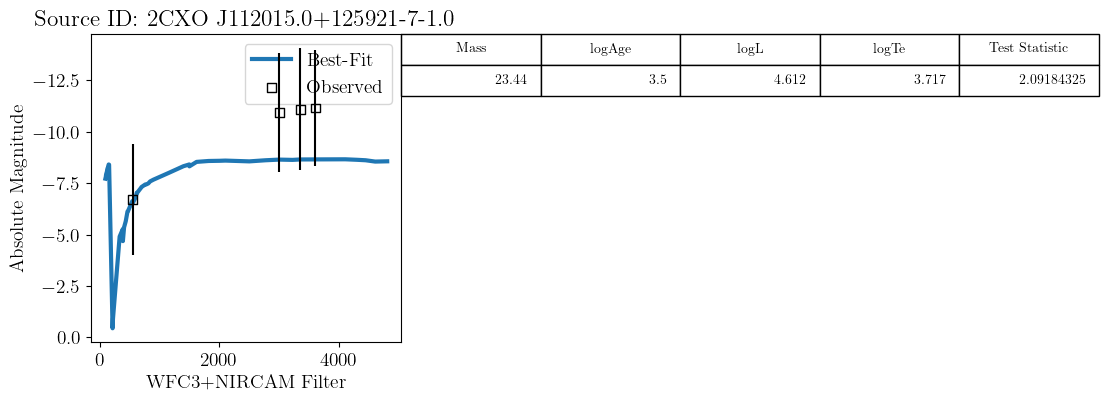

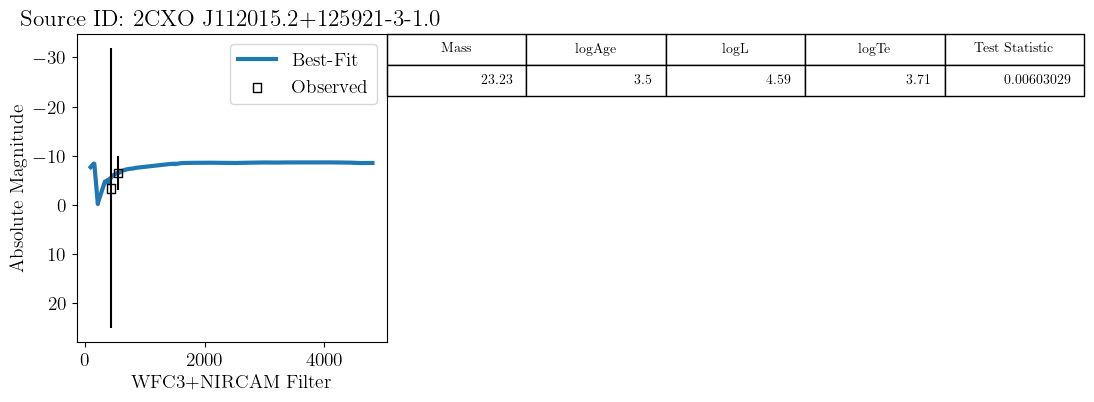

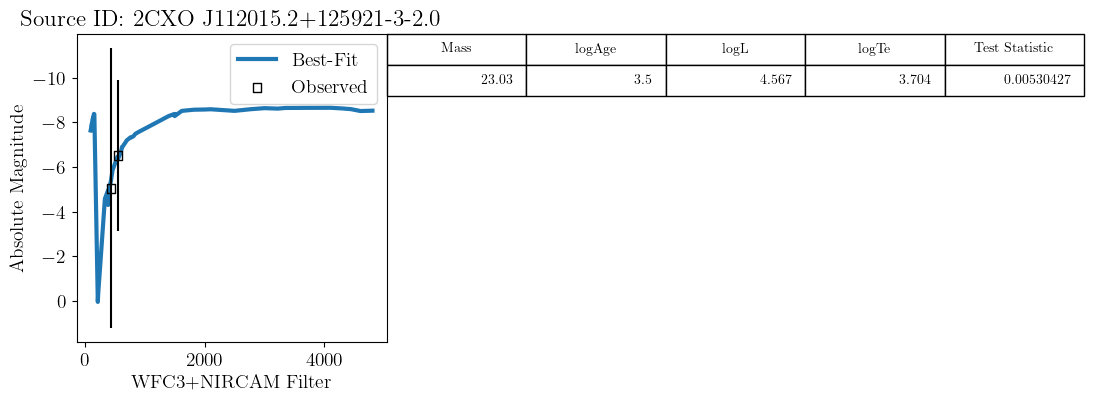

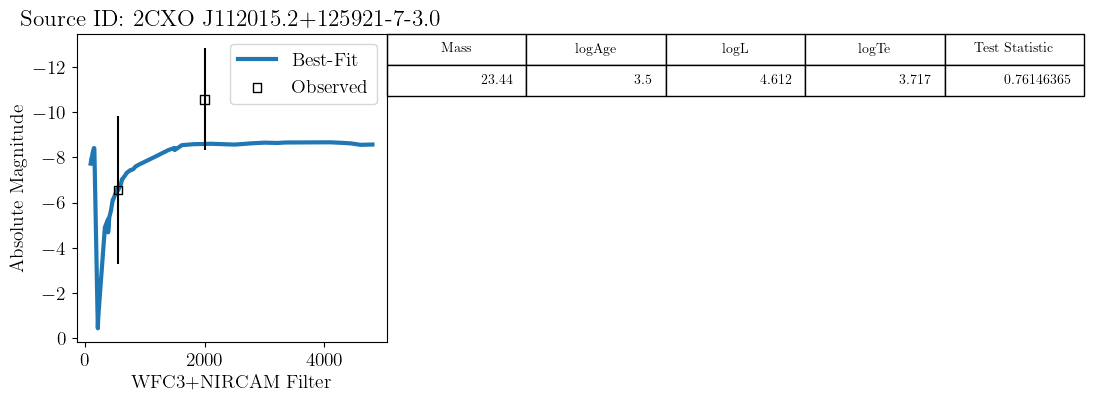

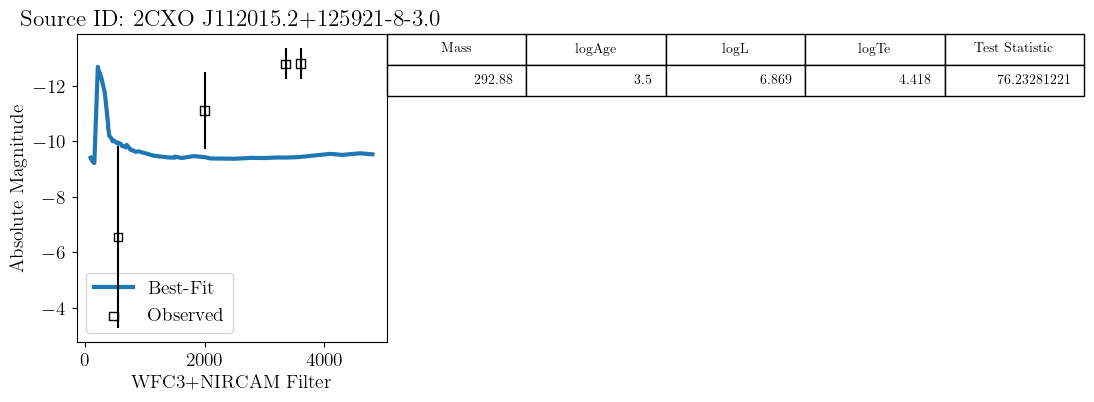

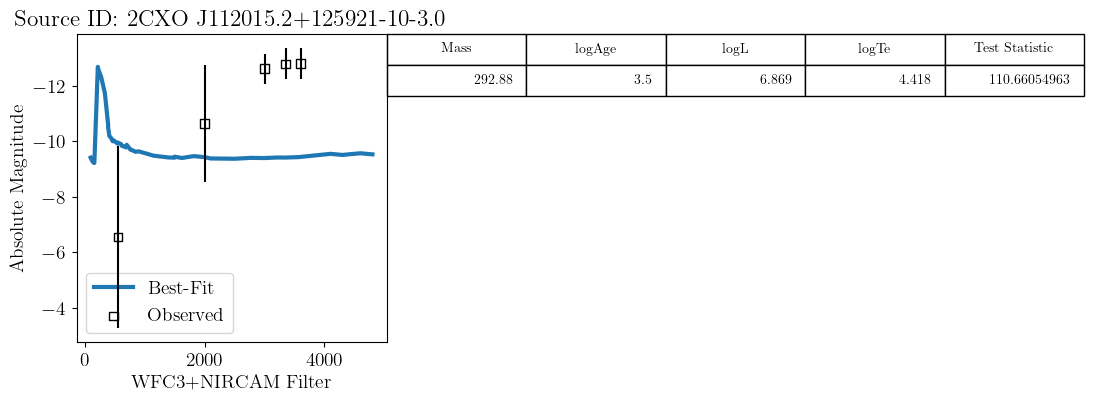

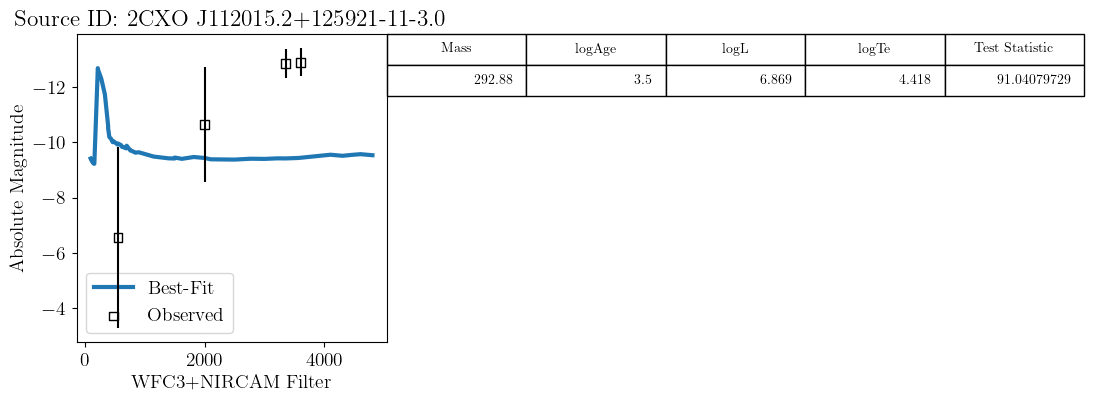

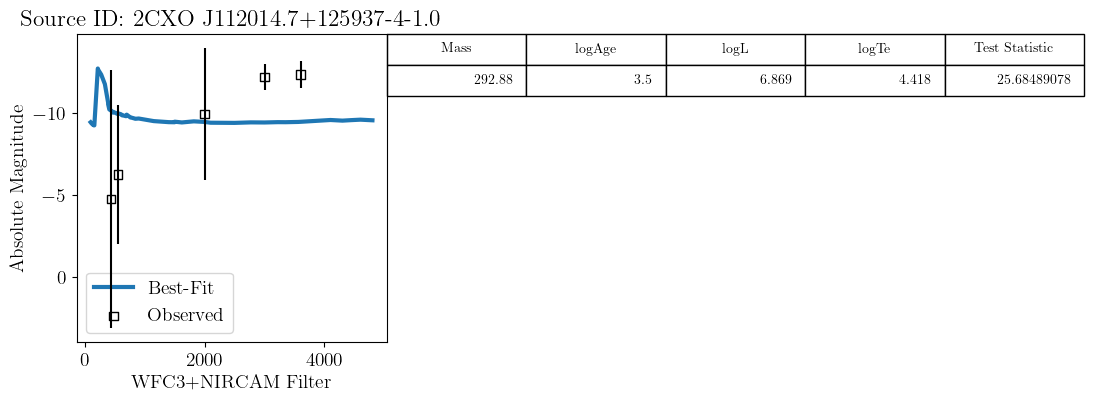

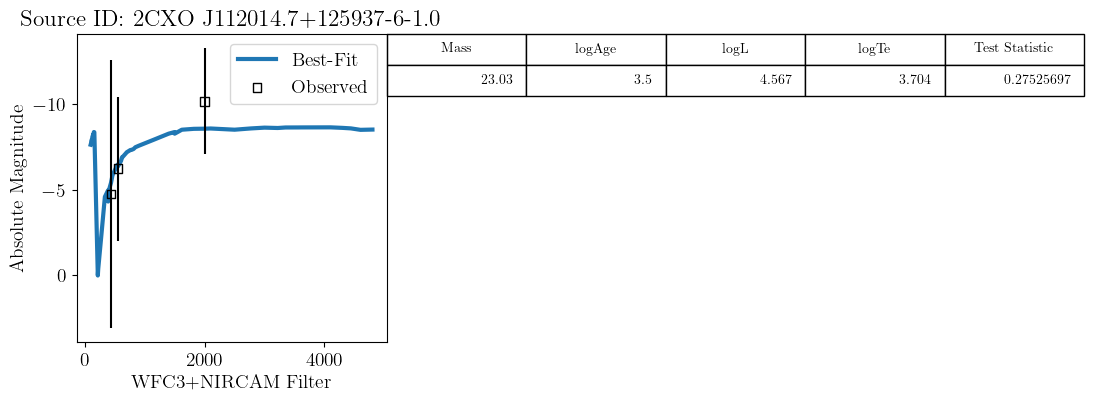

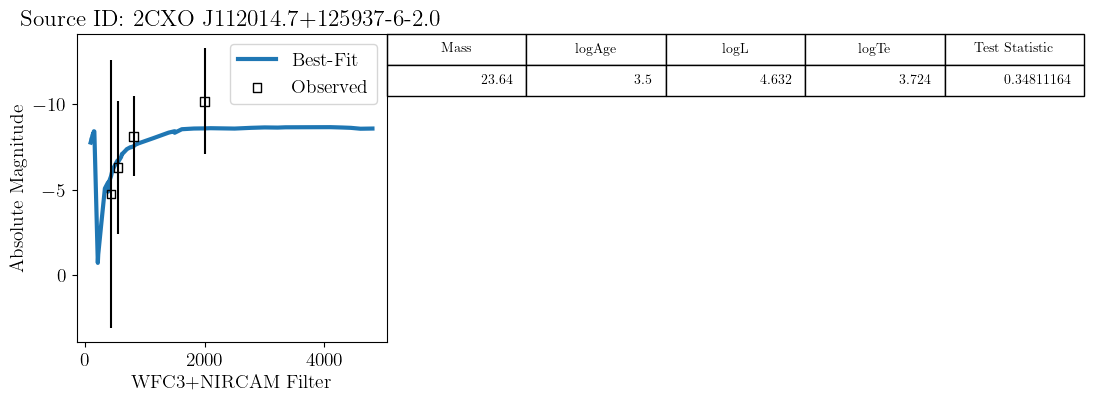

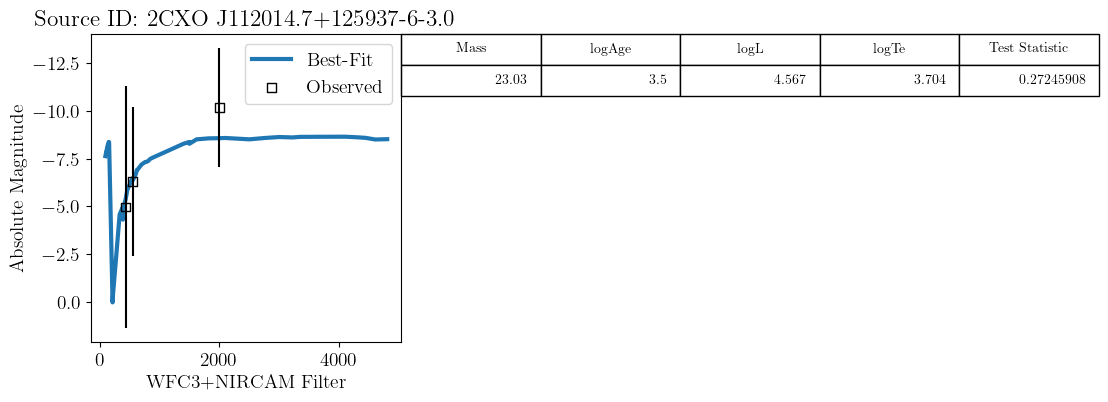

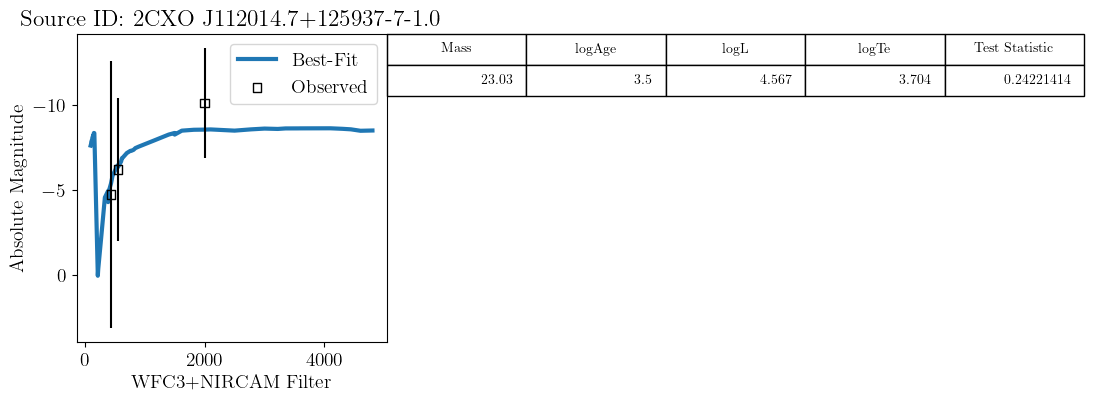

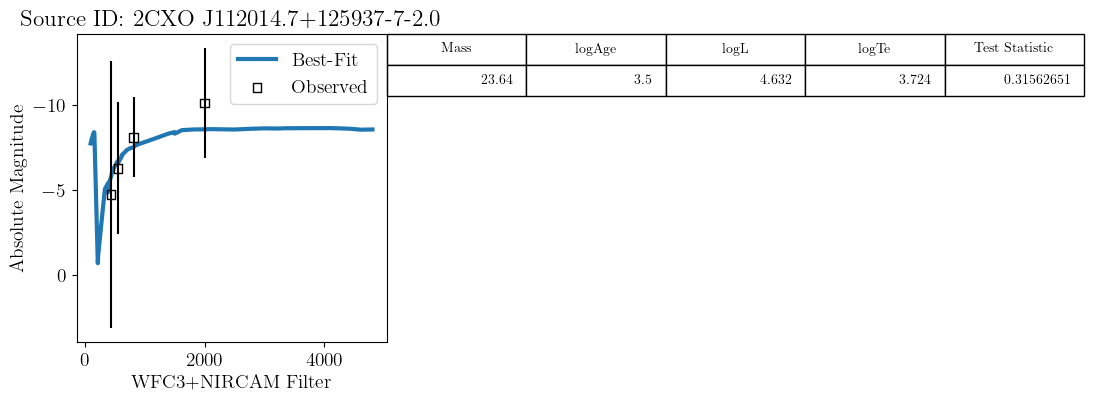

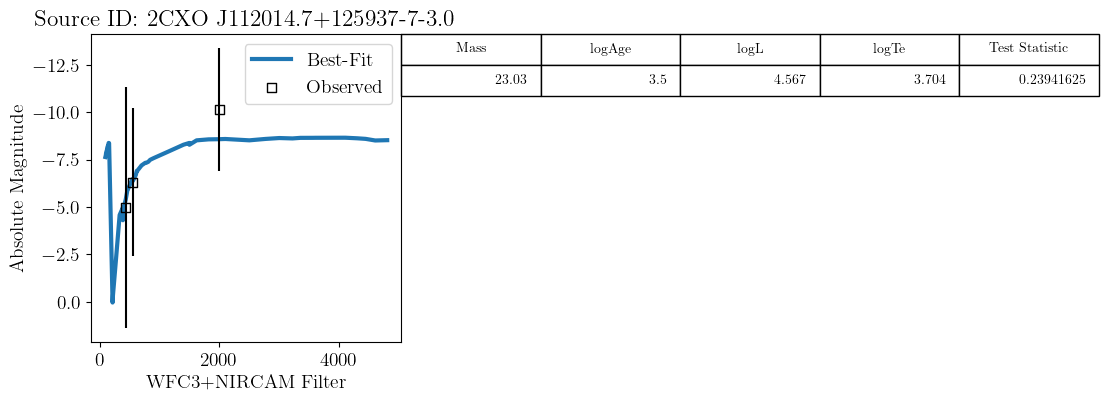

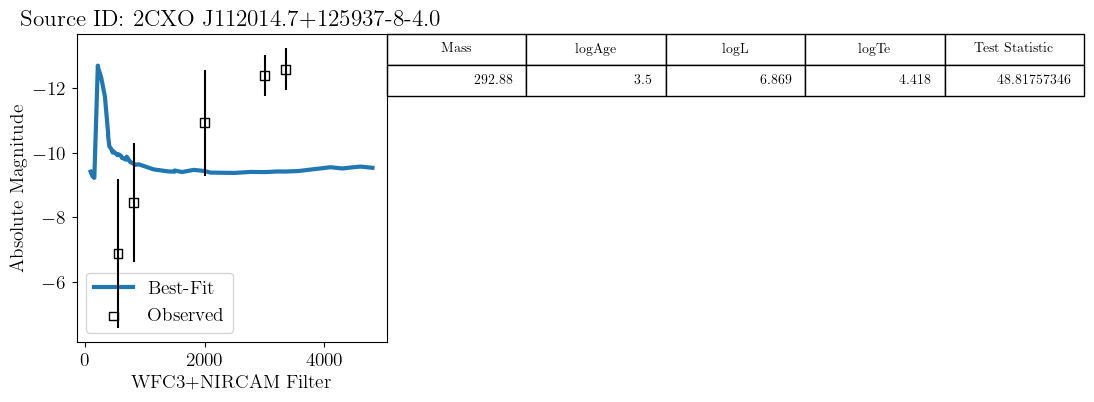

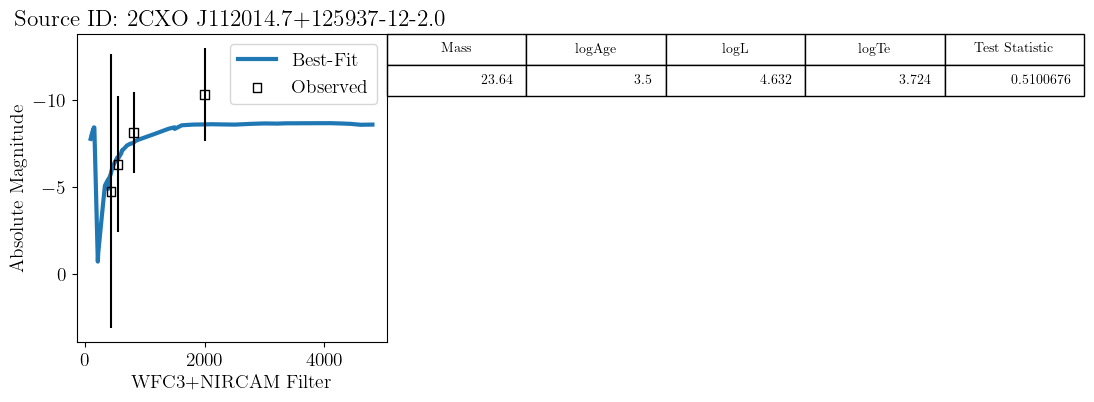

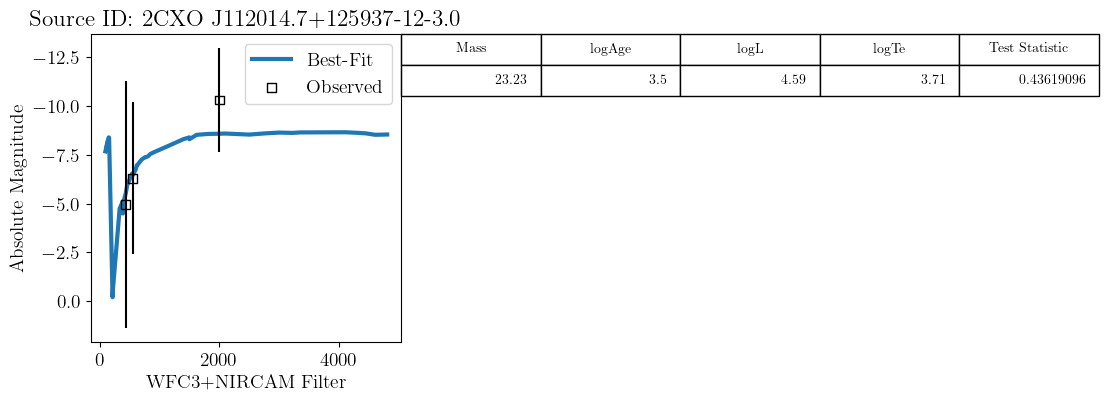

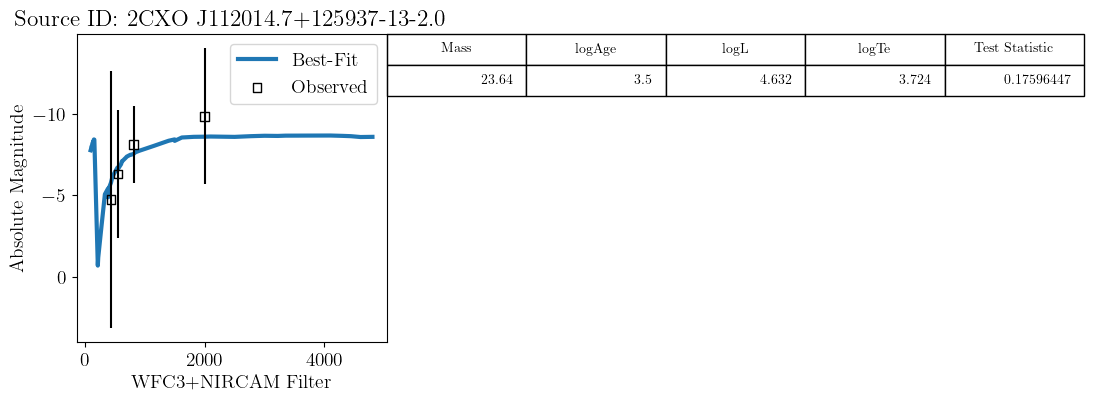

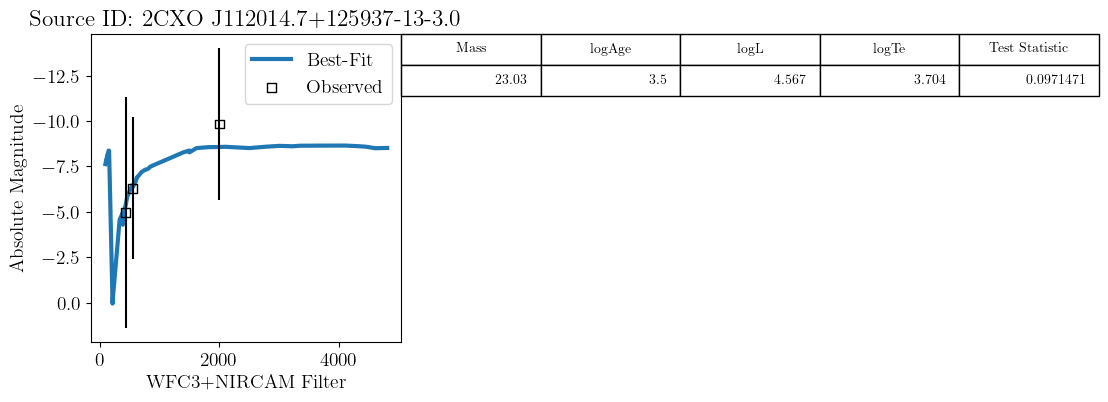

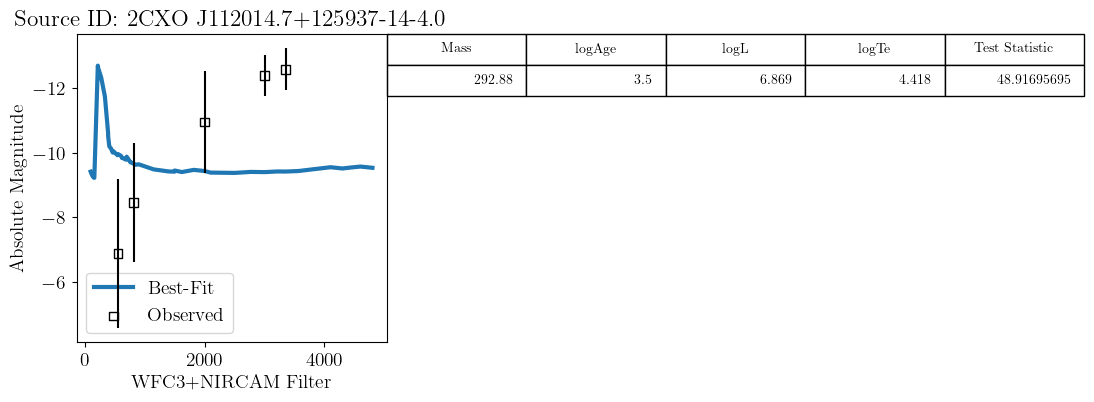

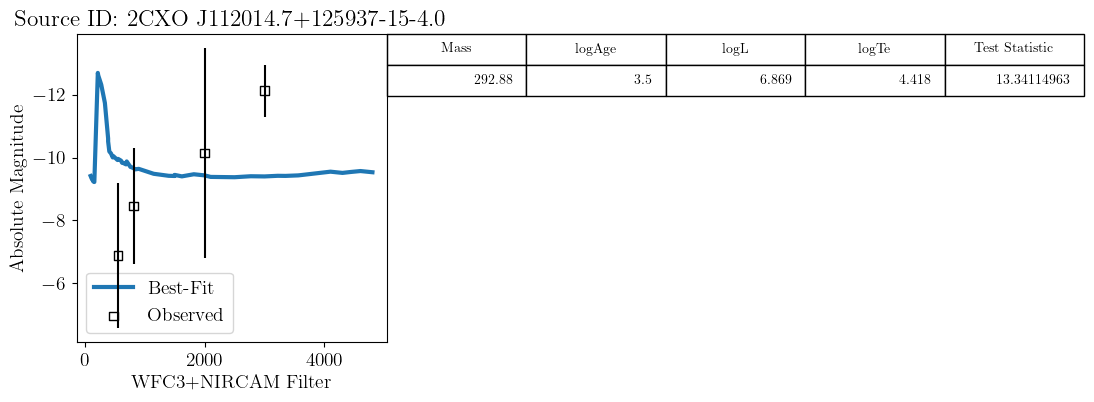

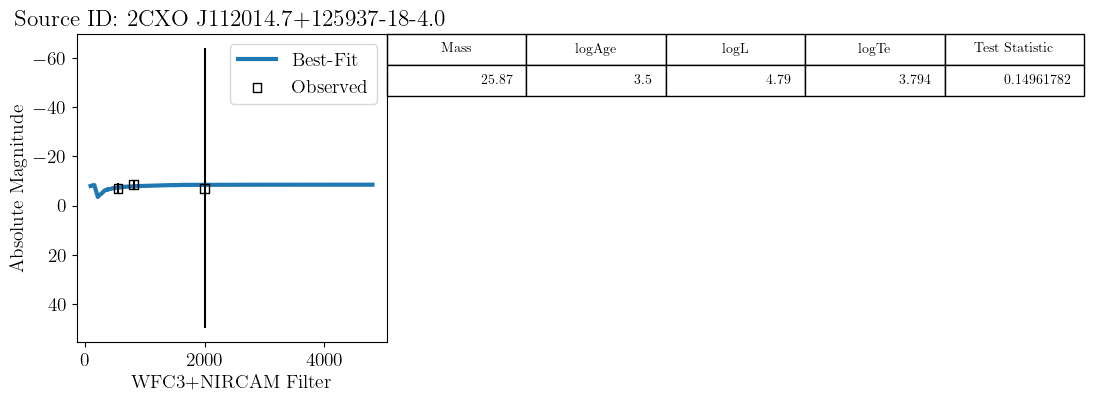

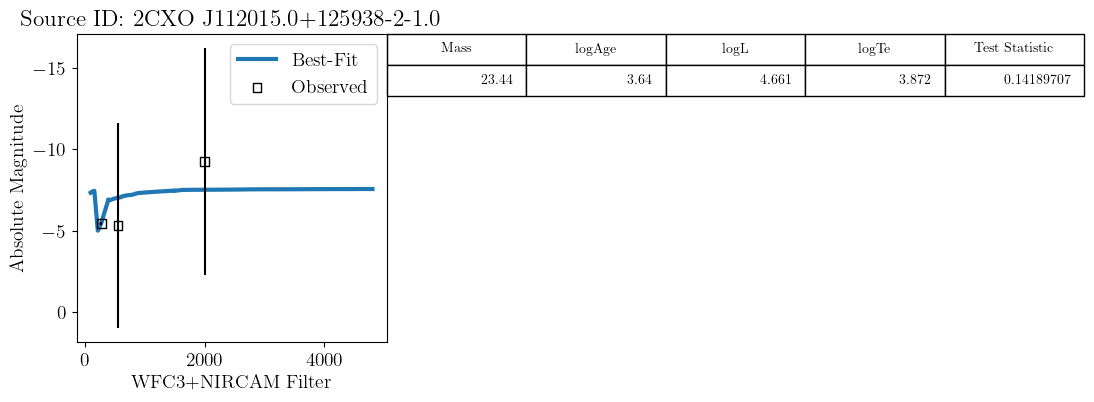

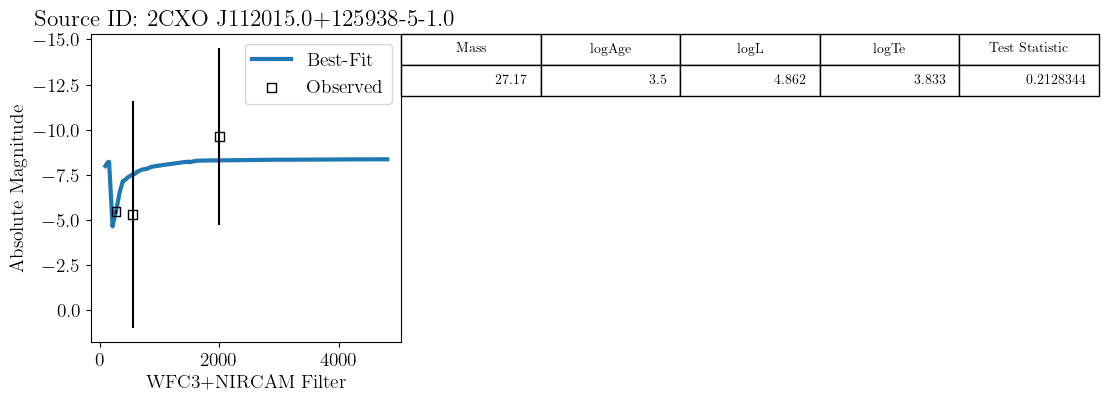

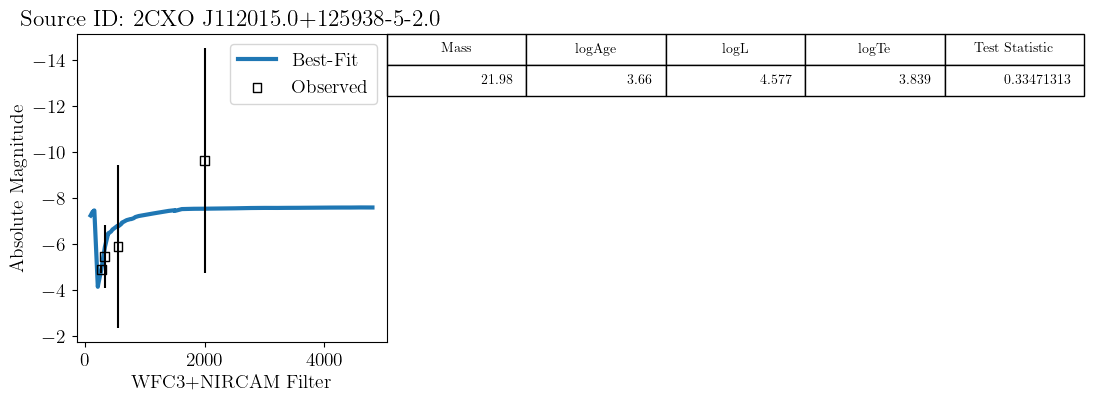

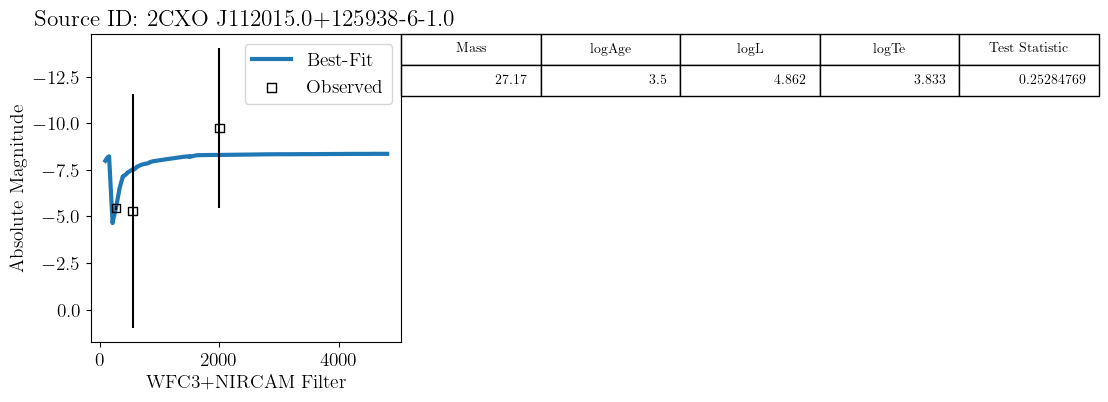

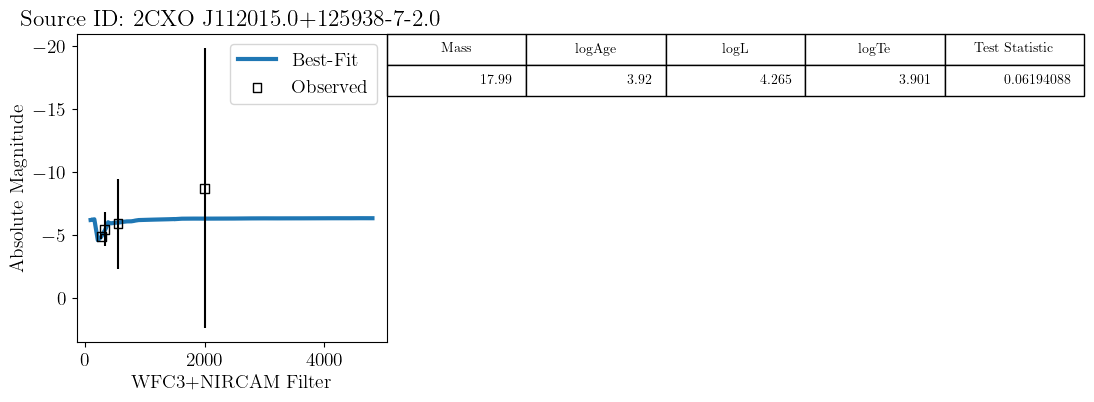

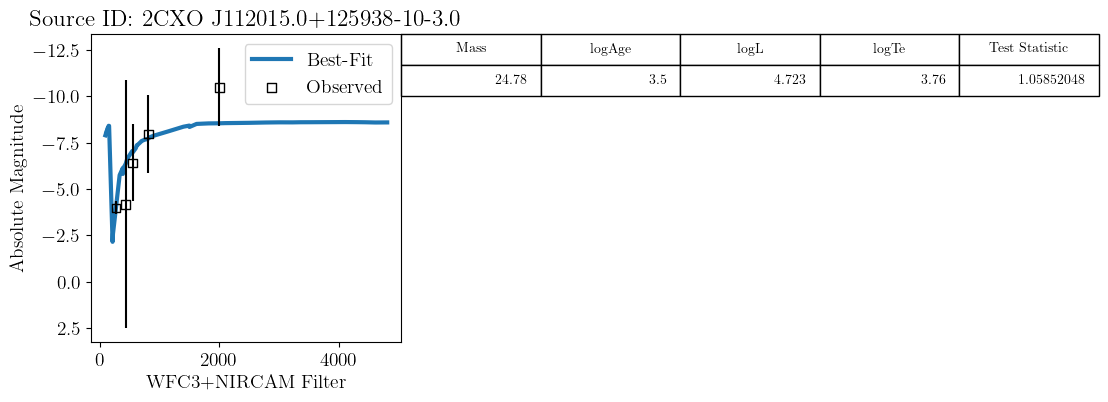

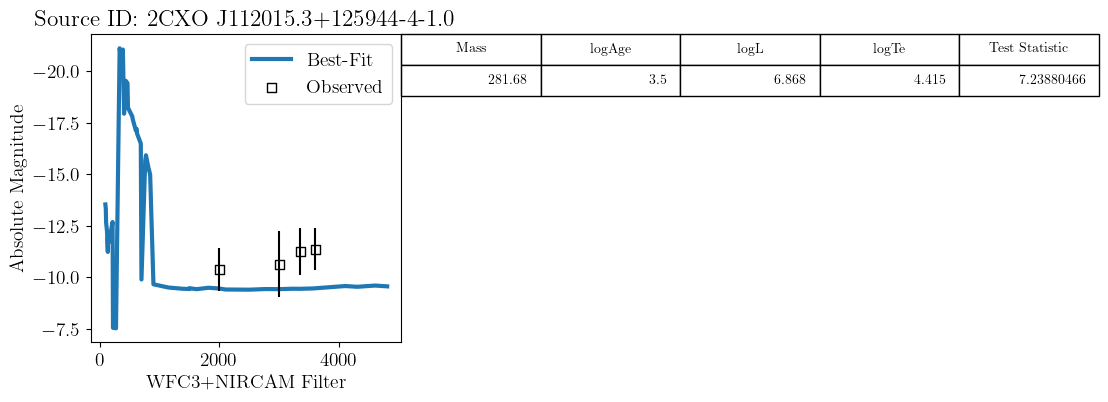

No best-fit model available for Source ID 2CXO J112015.3+125944-6-1.0.


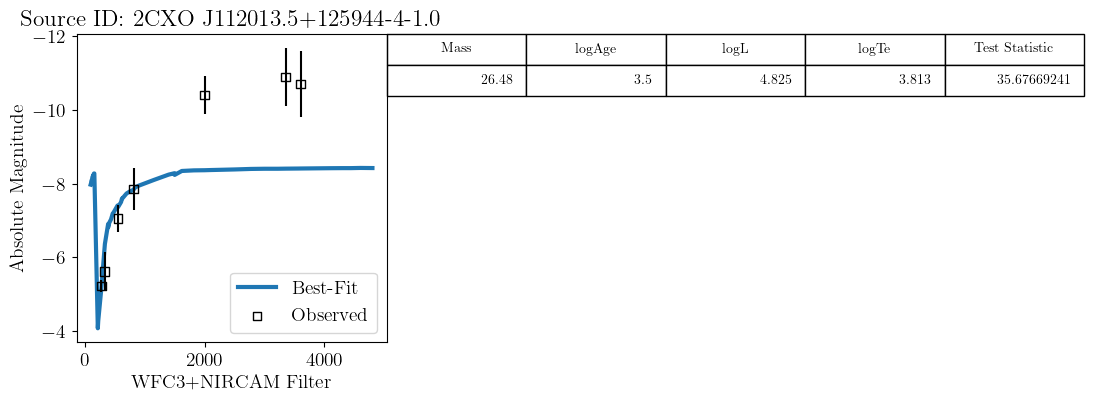

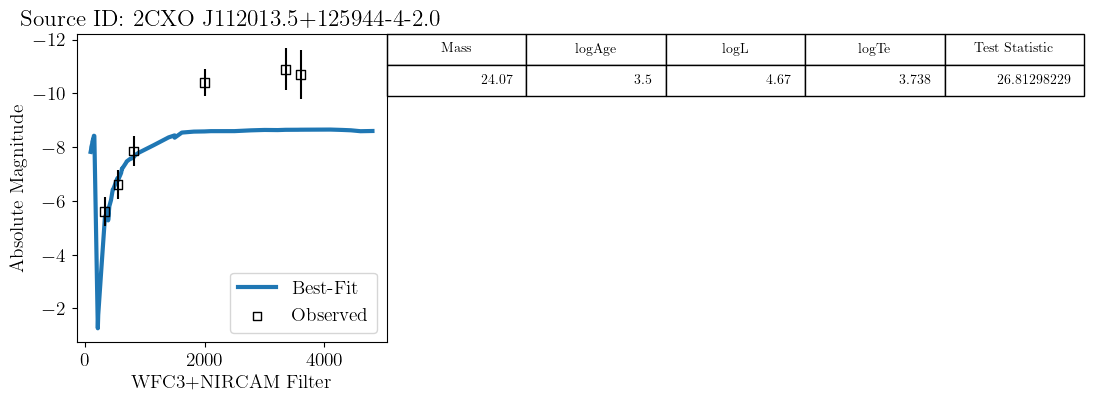

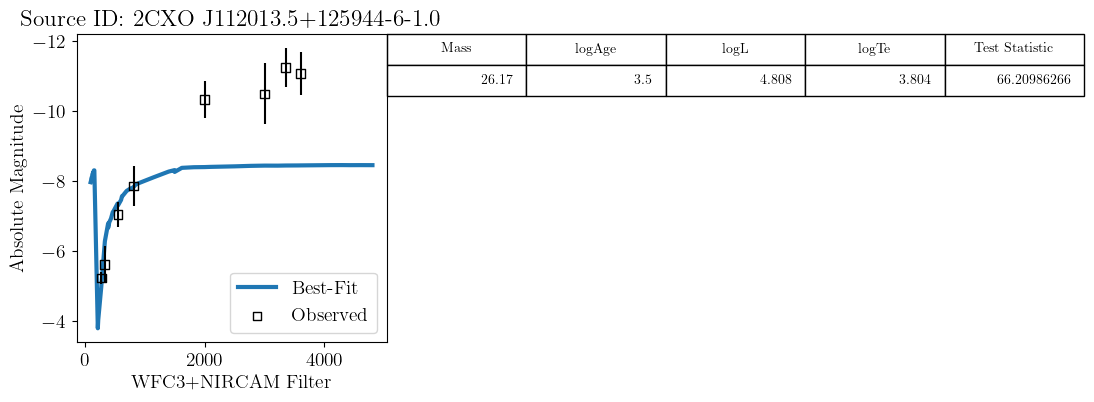

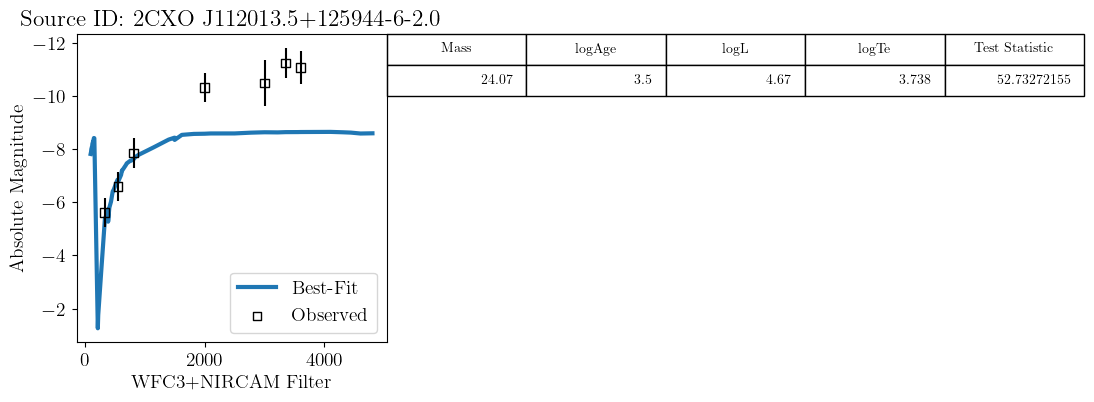

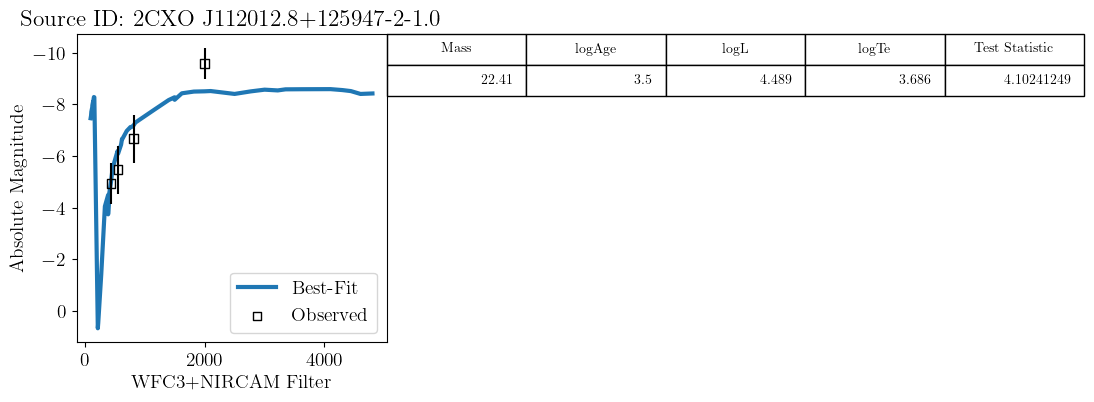

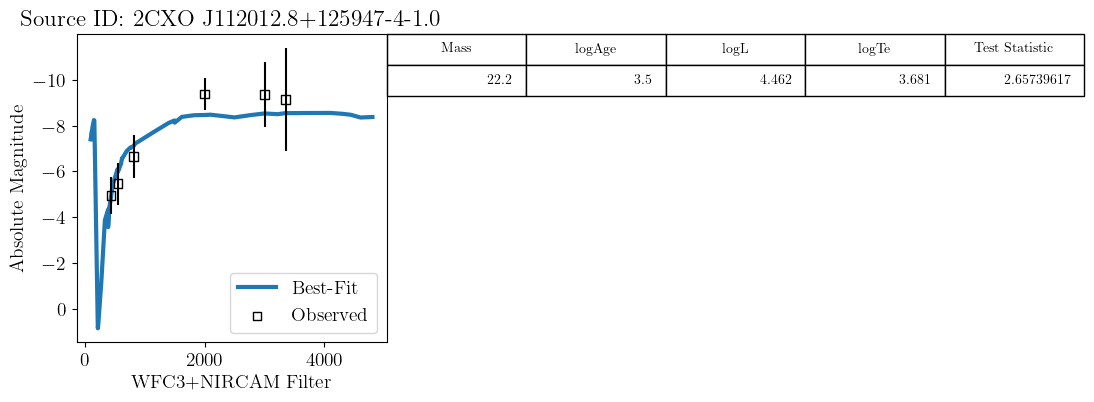

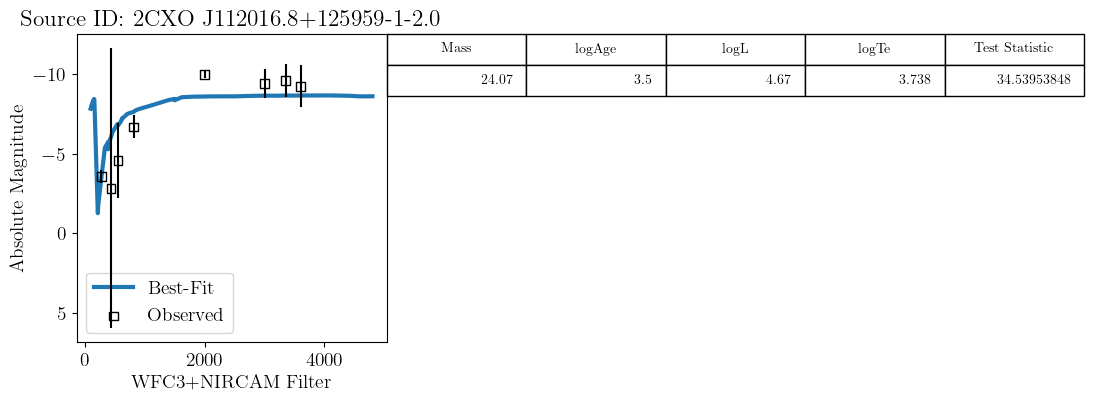

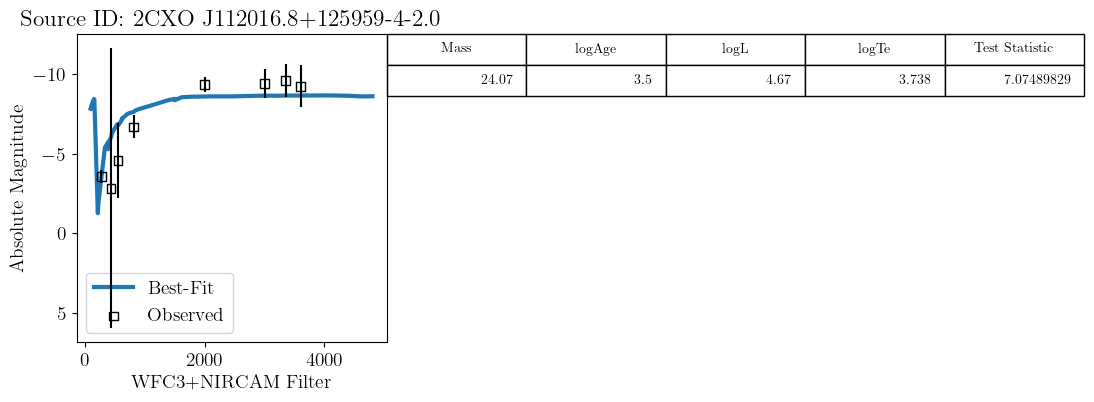

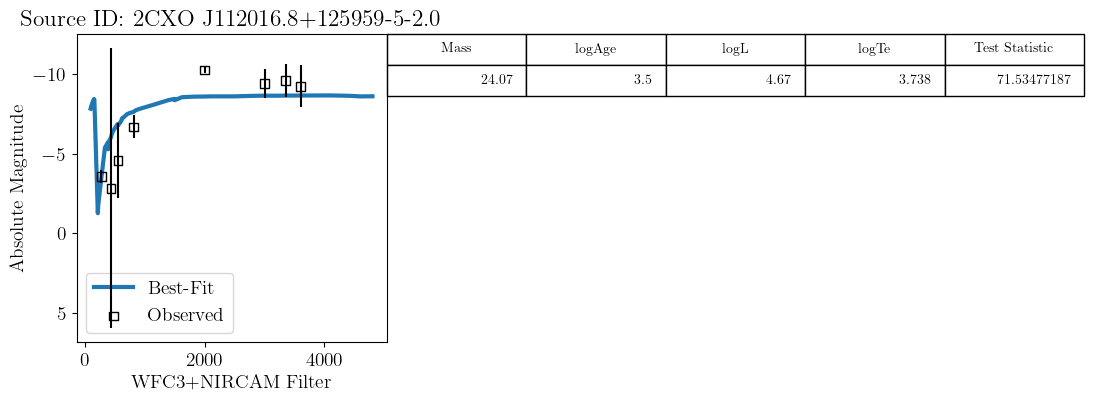

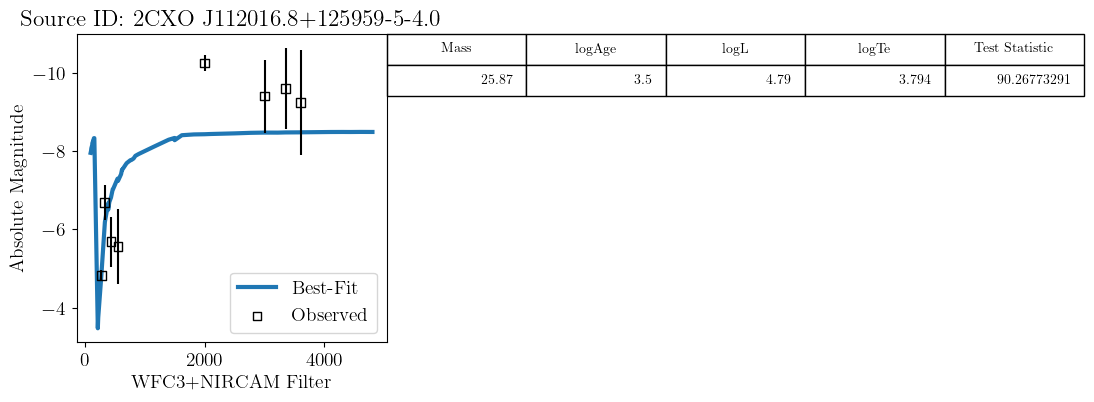

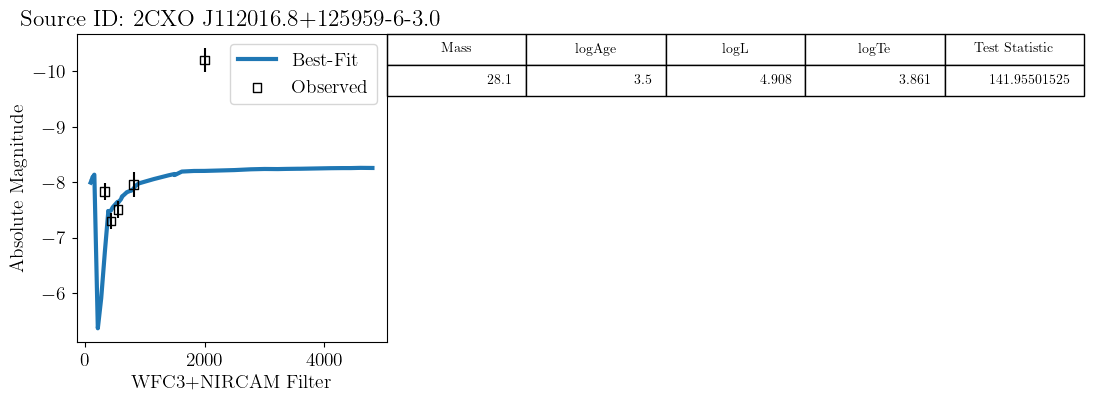

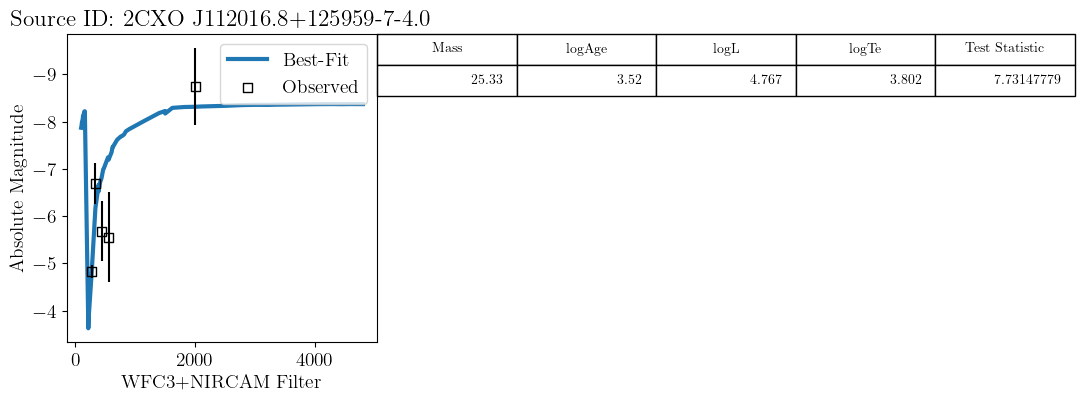

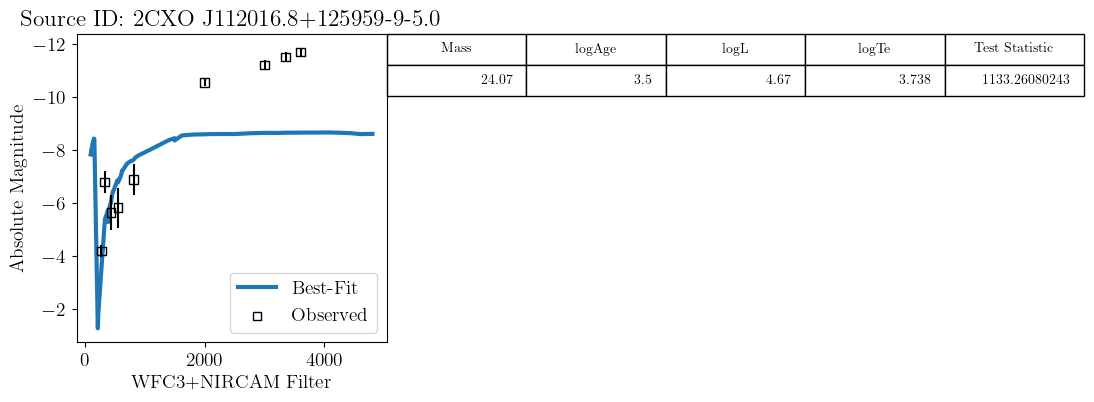

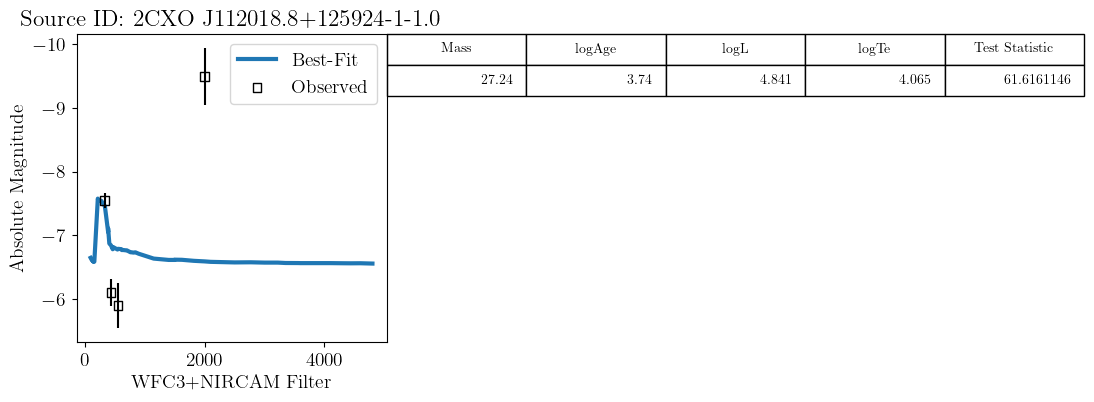

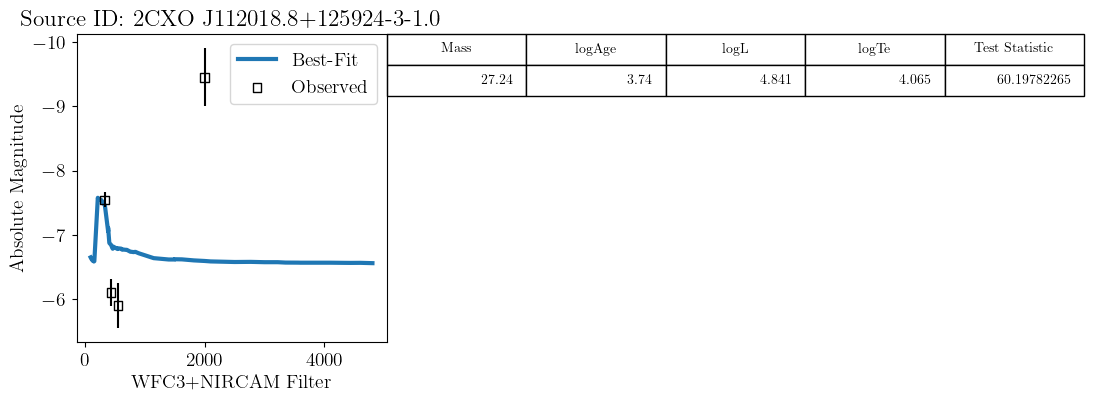

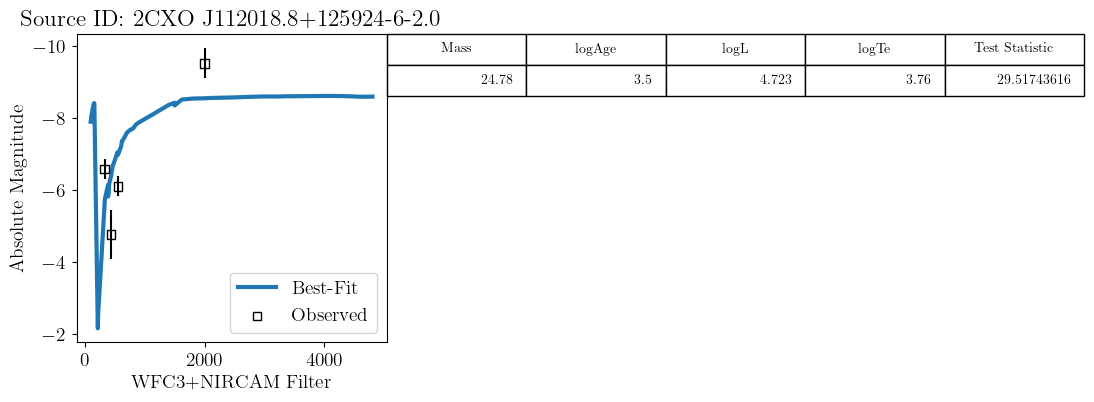

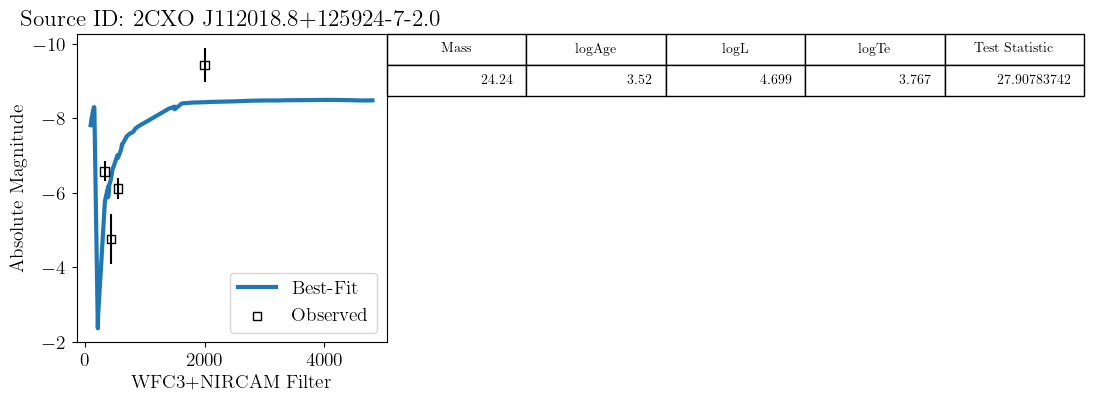

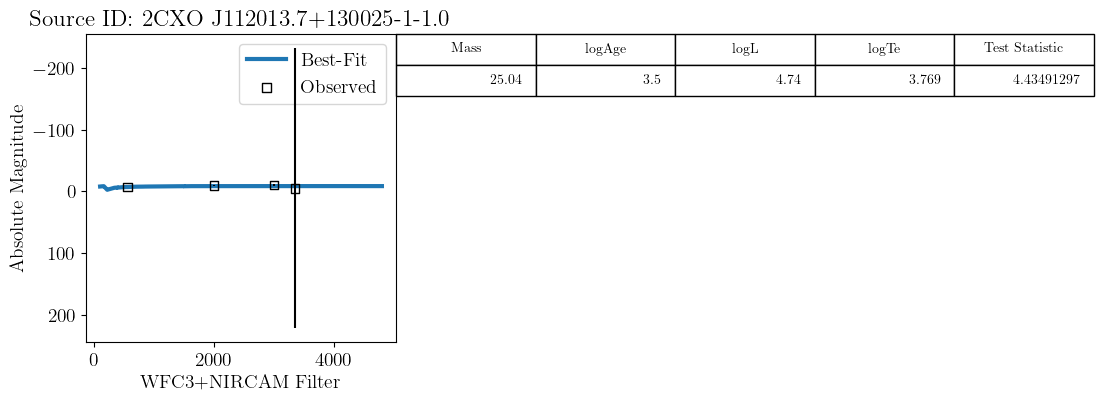

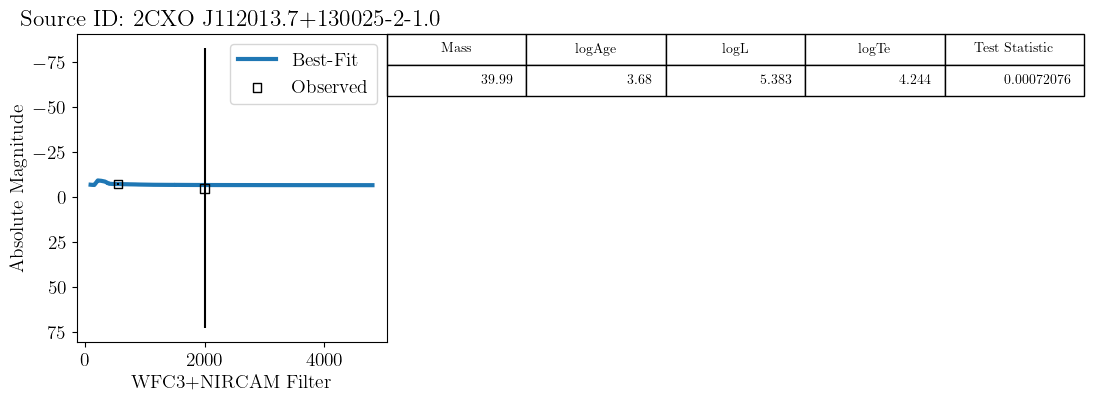

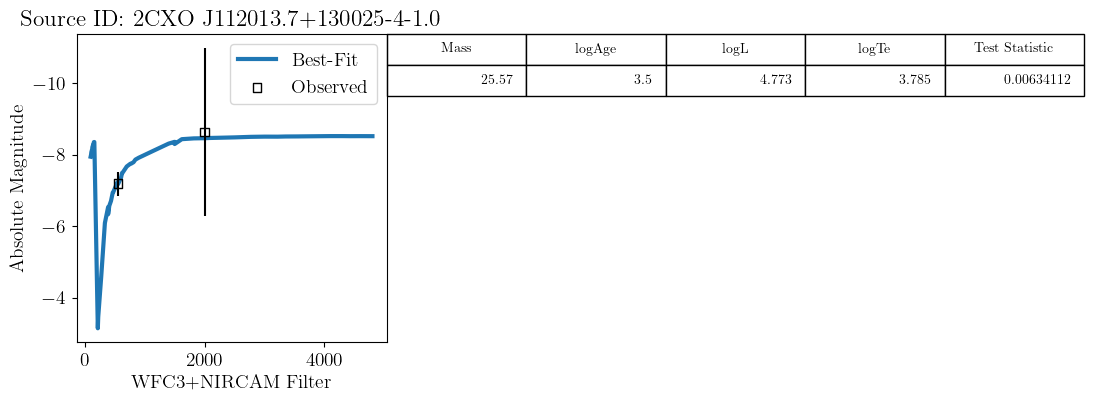

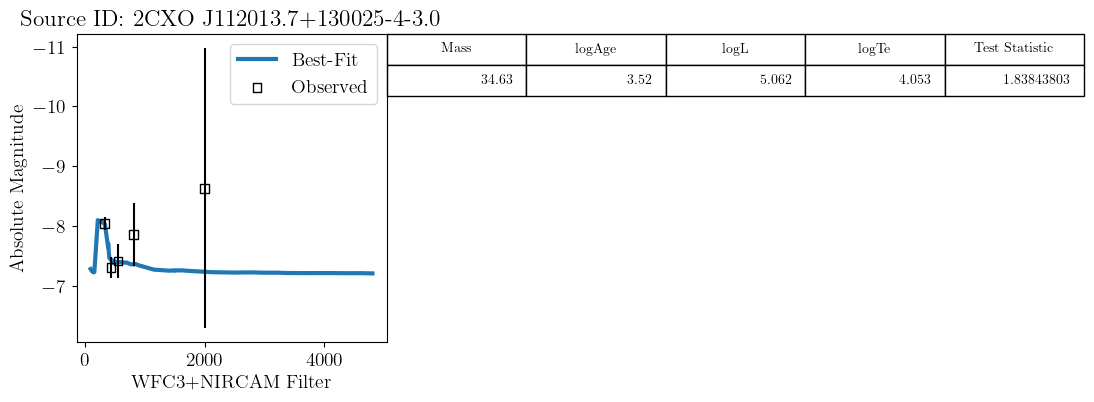

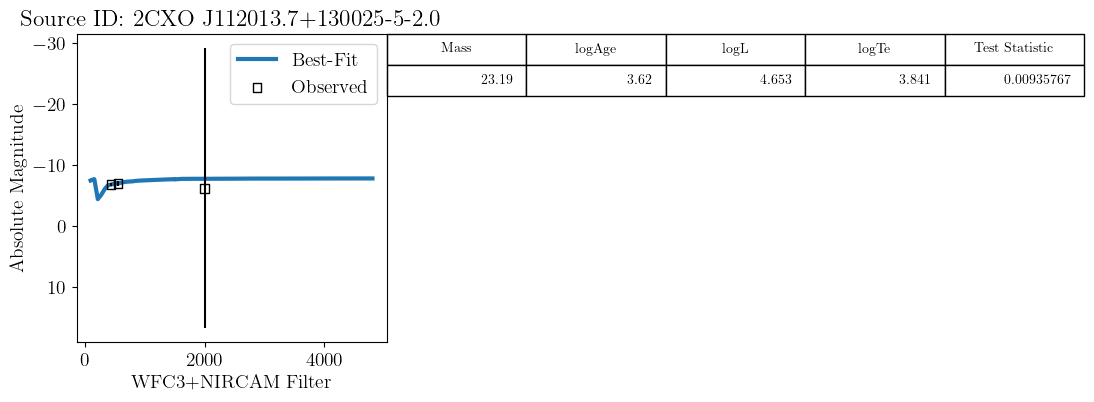

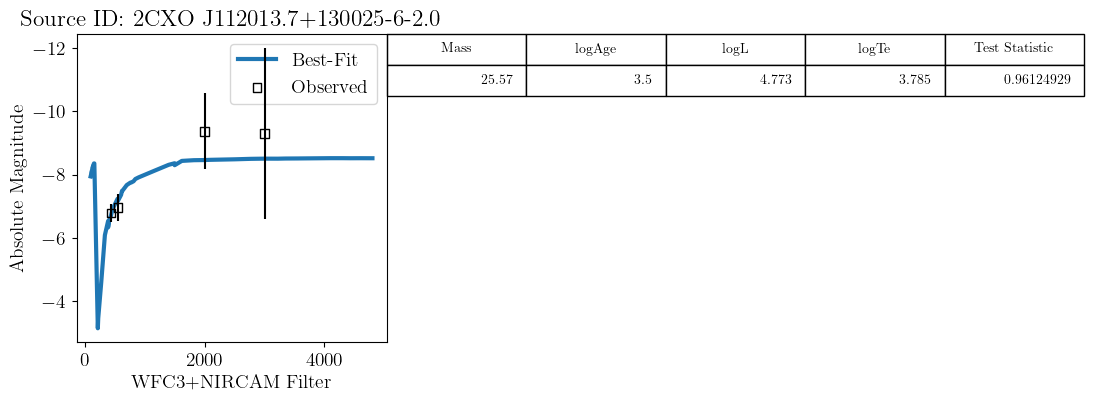

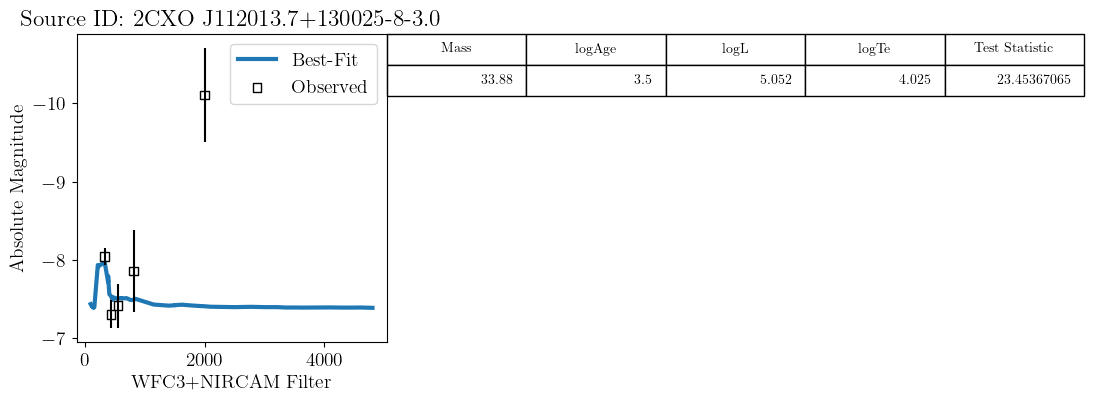

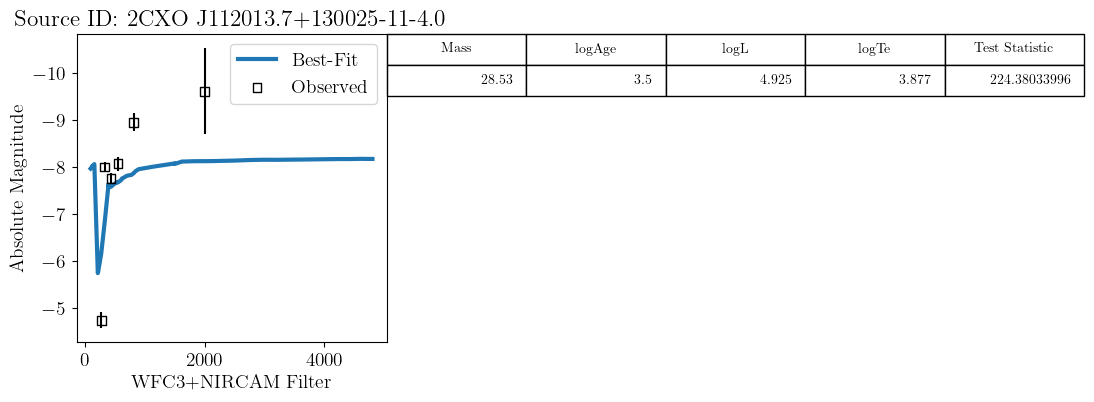

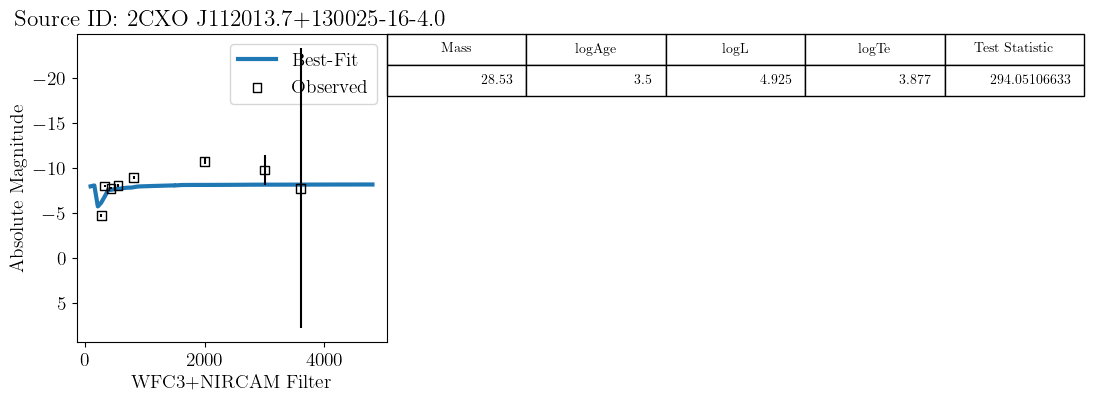

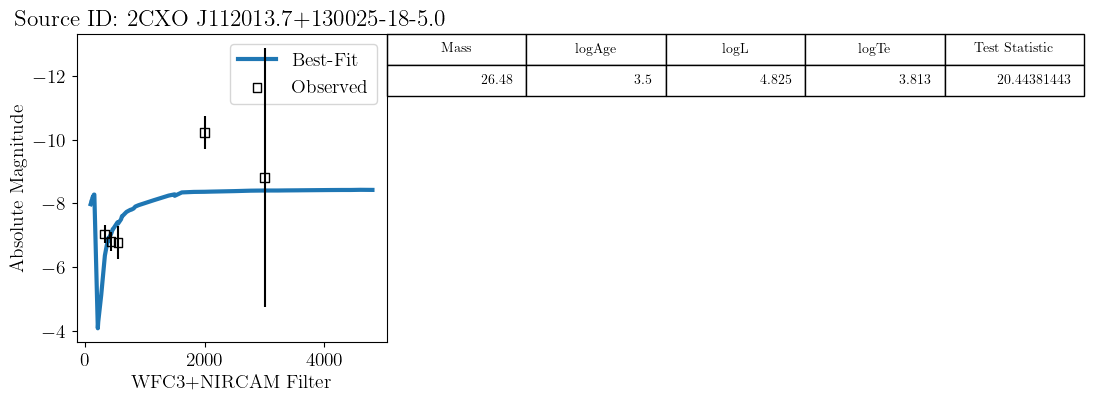

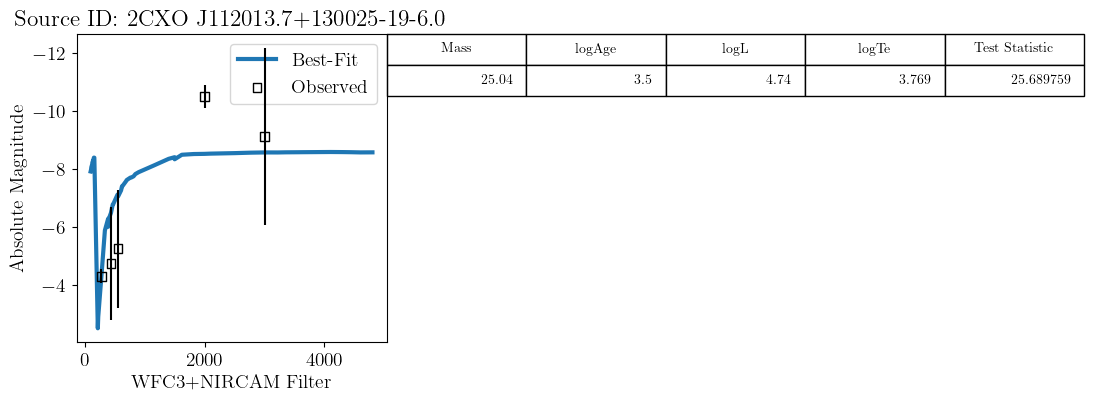

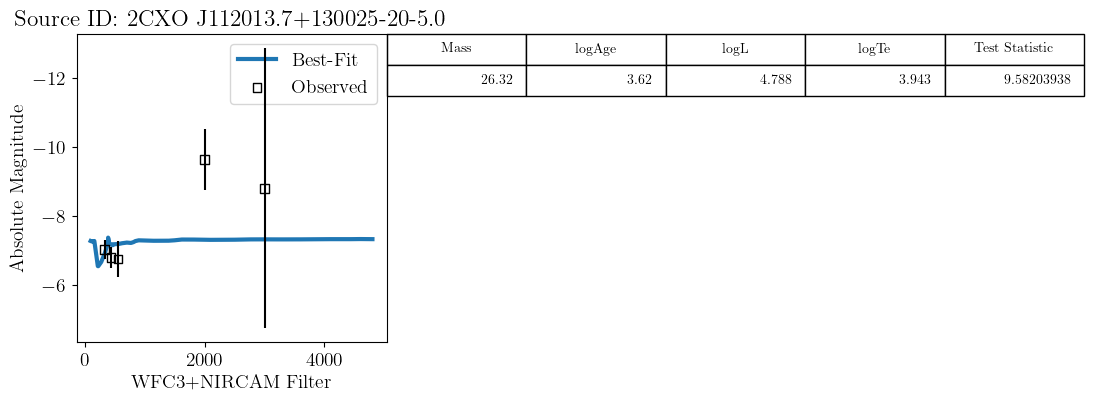

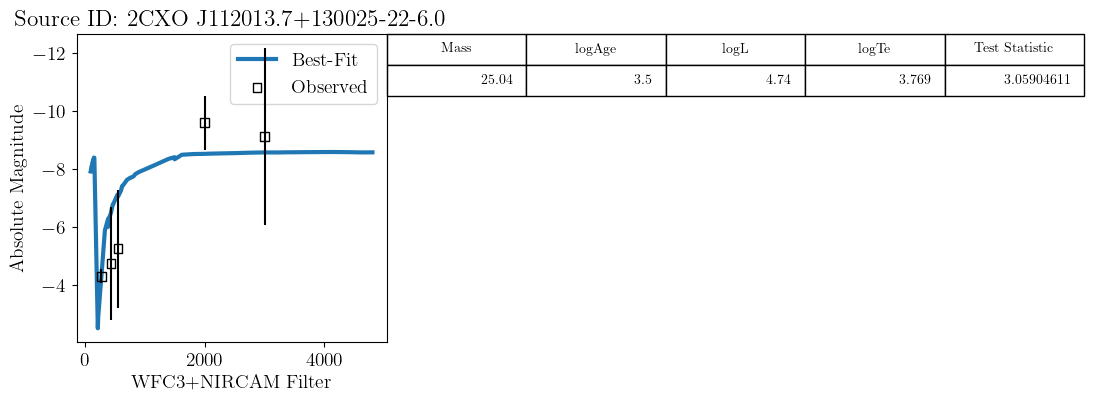

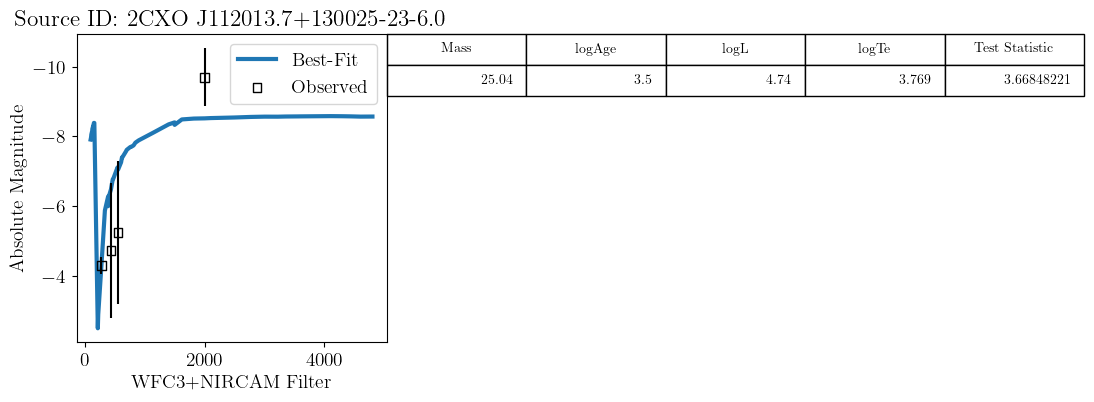

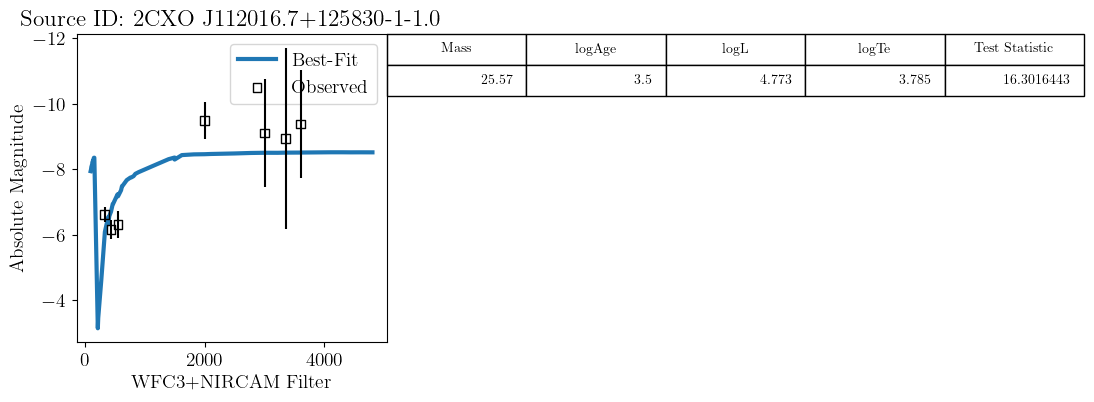

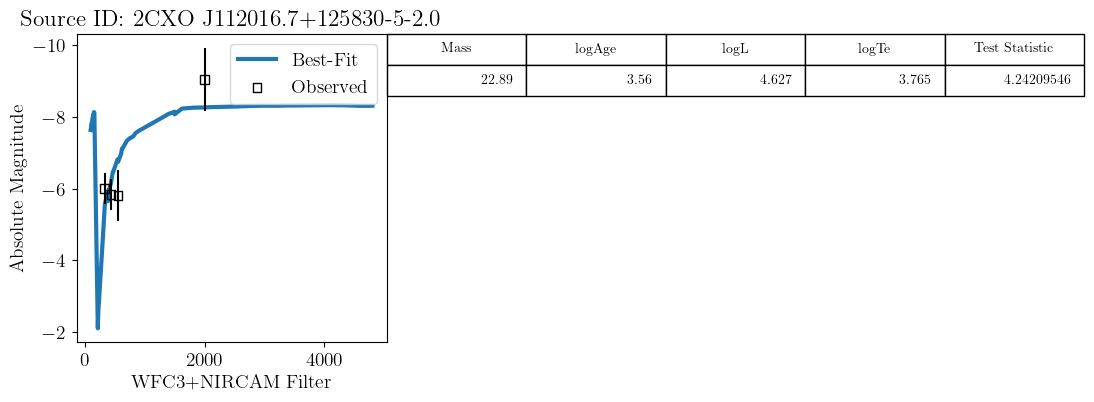

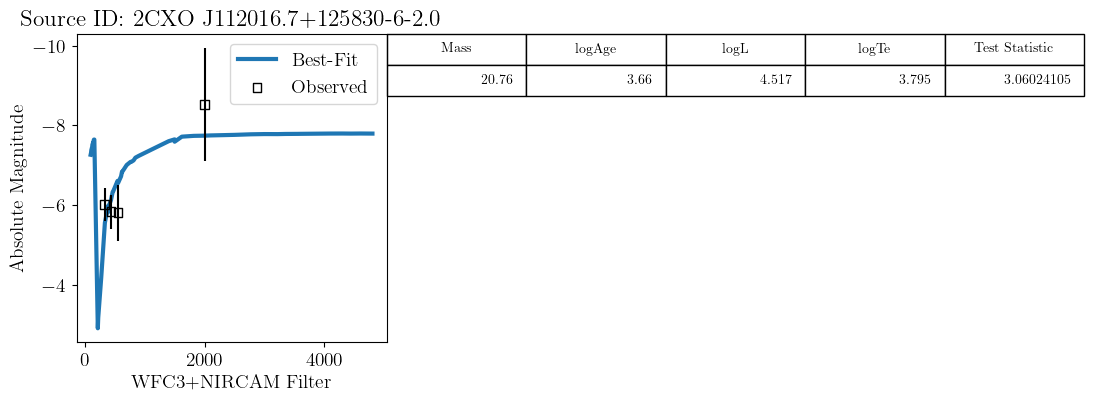

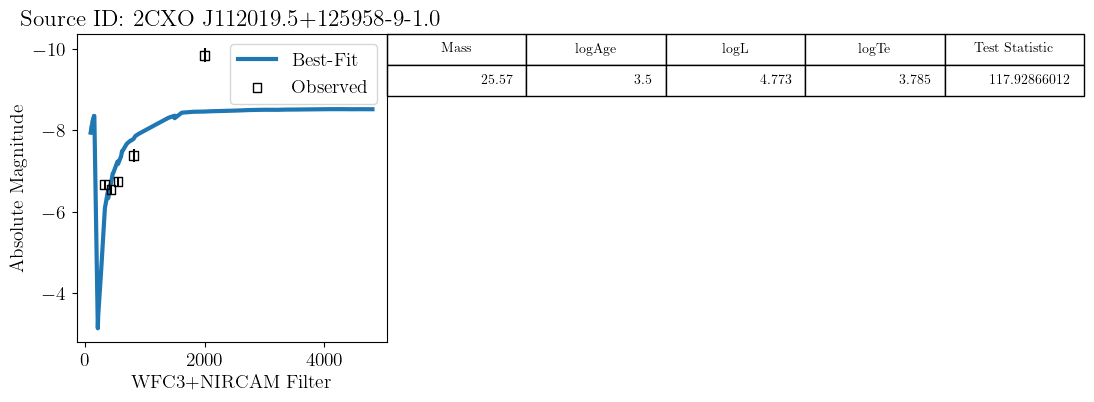

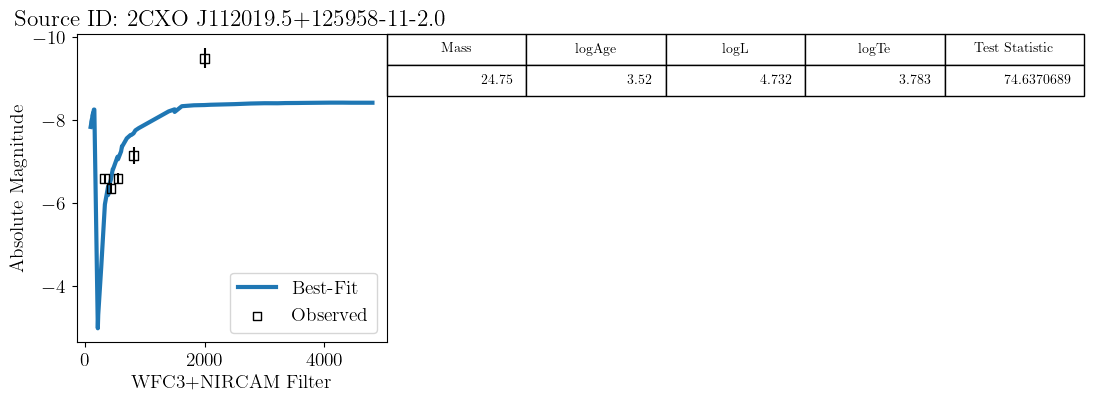

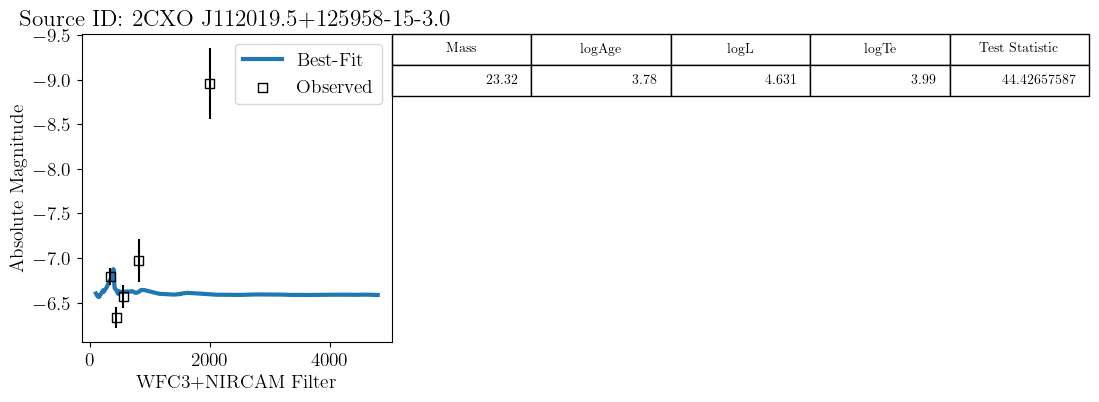

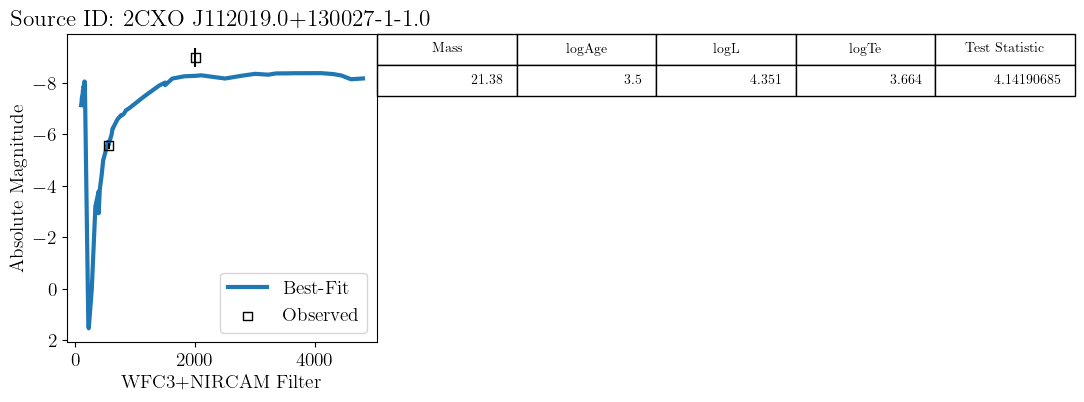

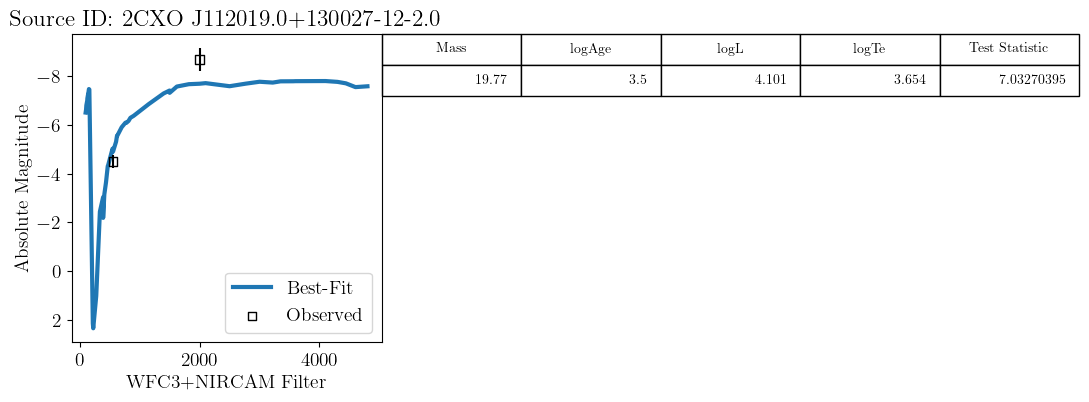

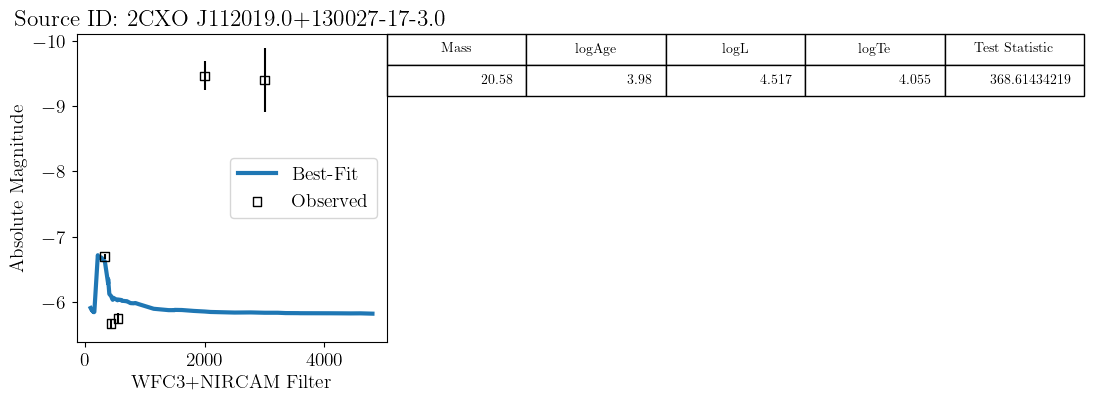

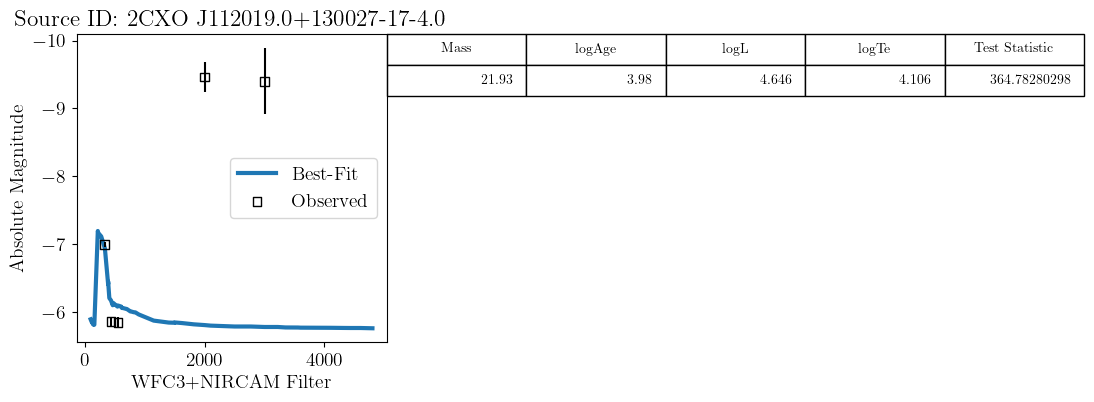

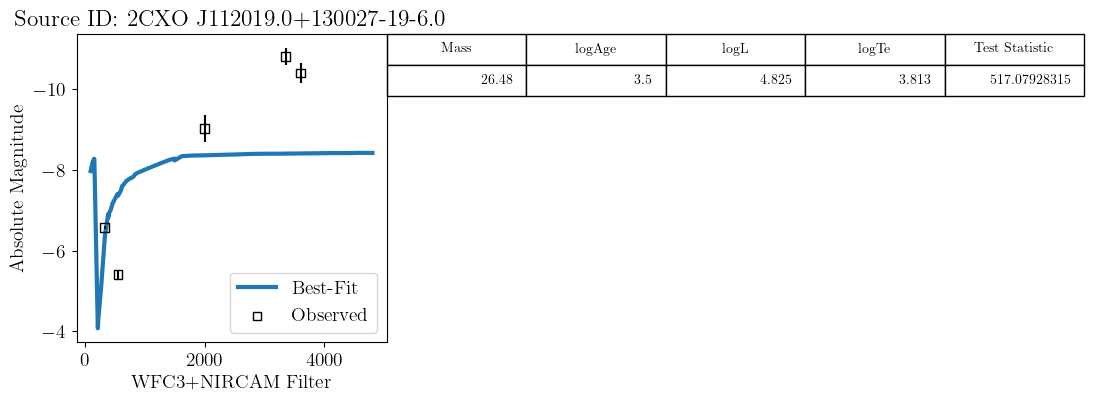

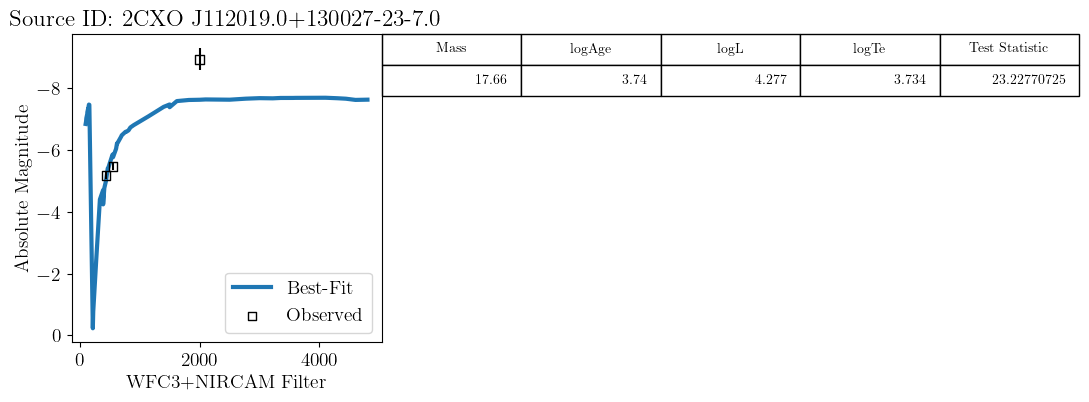

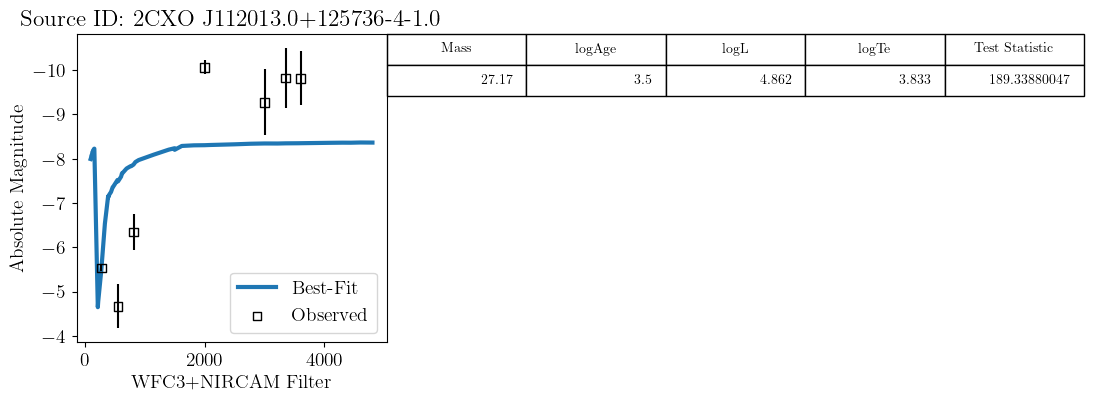

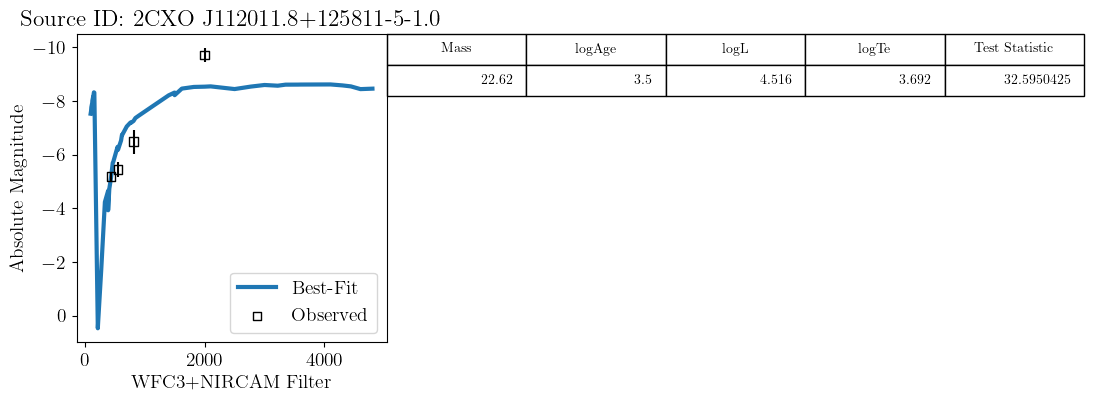

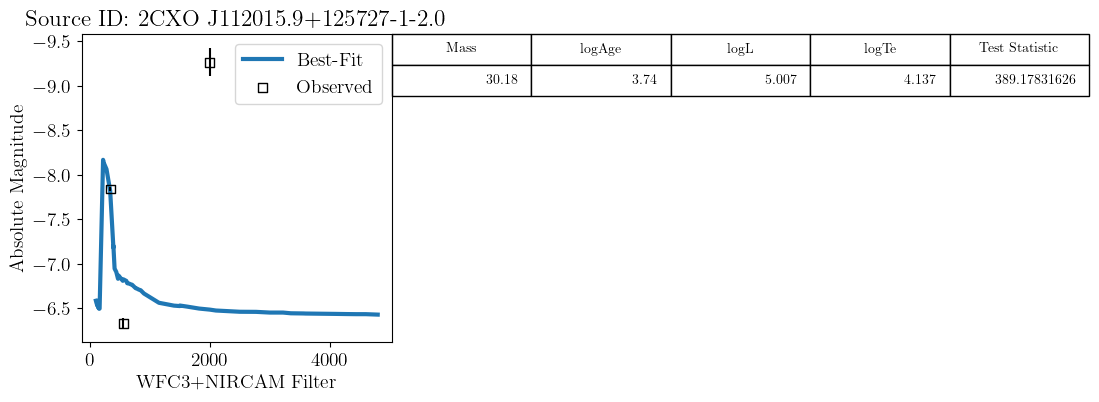

No best-fit model available for Source ID 2CXO J112015.3+125932-2-nan.
No best-fit model available for Source ID 2CXO J112014.1+125923-6-nan.


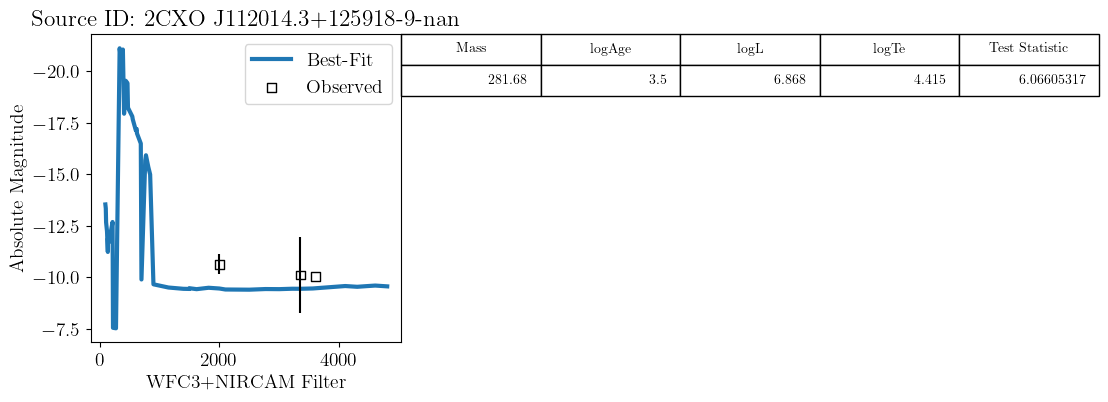

No best-fit model available for Source ID 2CXO J112014.5+125946-1-nan.
No best-fit model available for Source ID 2CXO J112015.8+125910-4-nan.
No best-fit model available for Source ID 2CXO J112013.4+125928-3-nan.


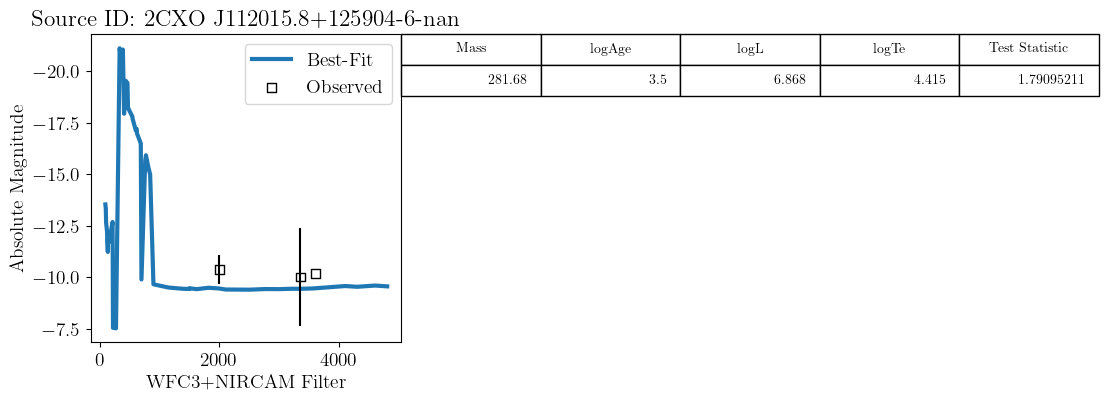

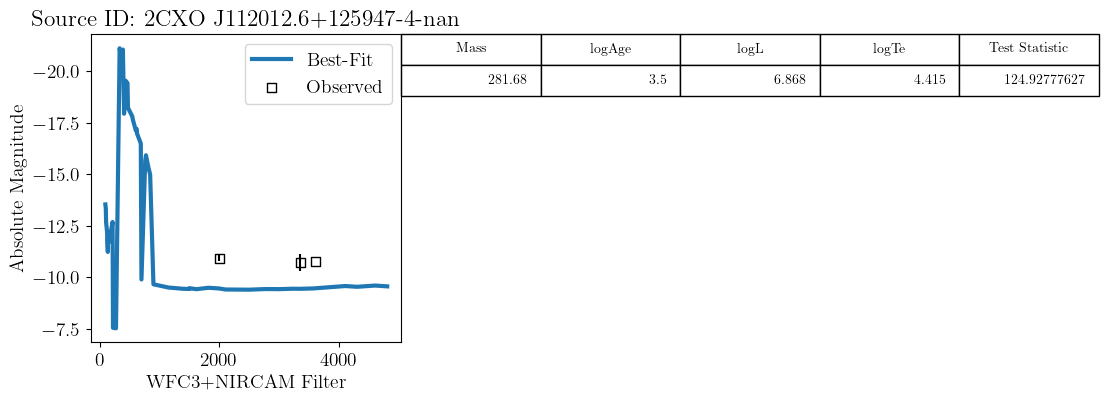

No best-fit model available for Source ID 2CXO J112017.1+130003-6-nan.
No best-fit model available for Source ID 2CXO J112012.2+125952-9-nan.
No best-fit model available for Source ID 2CXO J112012.0+125910-3-nan.


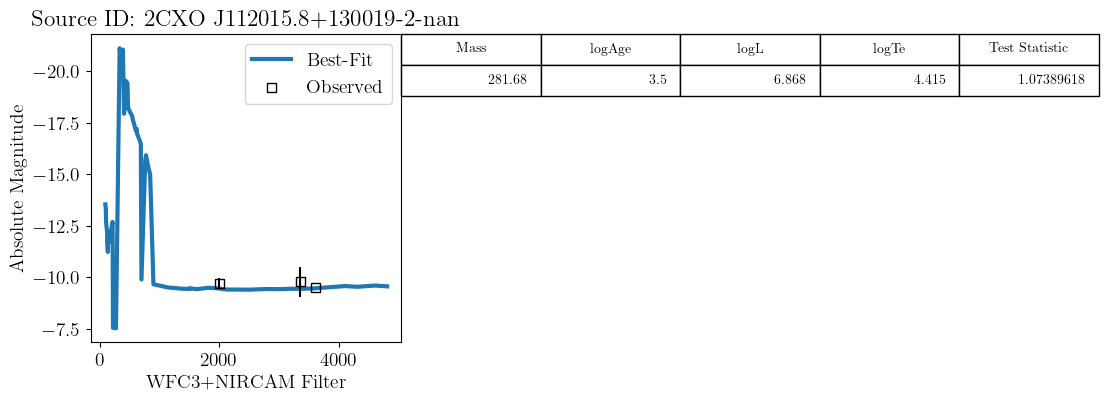

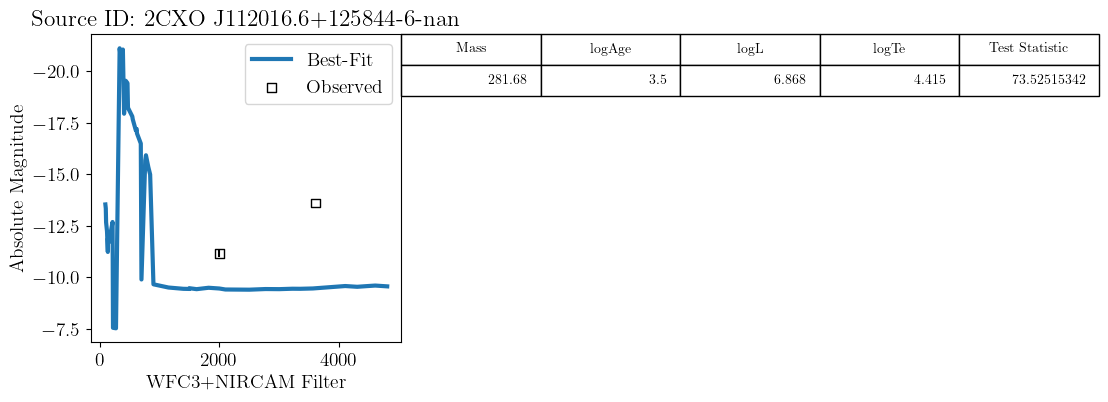

No best-fit model available for Source ID 2CXO J112018.2+125959-1-nan.
No best-fit model available for Source ID 2CXO J112012.3+125846-1-nan.
No best-fit model available for Source ID 2CXO J112011.3+125904-2-nan.
No best-fit model available for Source ID 2CXO J112017.3+130019-6-nan.
No best-fit model available for Source ID 2CXO J112017.6+130017-1-nan.
No best-fit model available for Source ID 2CXO J112017.1+130025-3-nan.
No best-fit model available for Source ID 2CXO J112016.4+130034-22-nan.
No best-fit model available for Source ID 2CXO J112018.7+130027-1-nan.


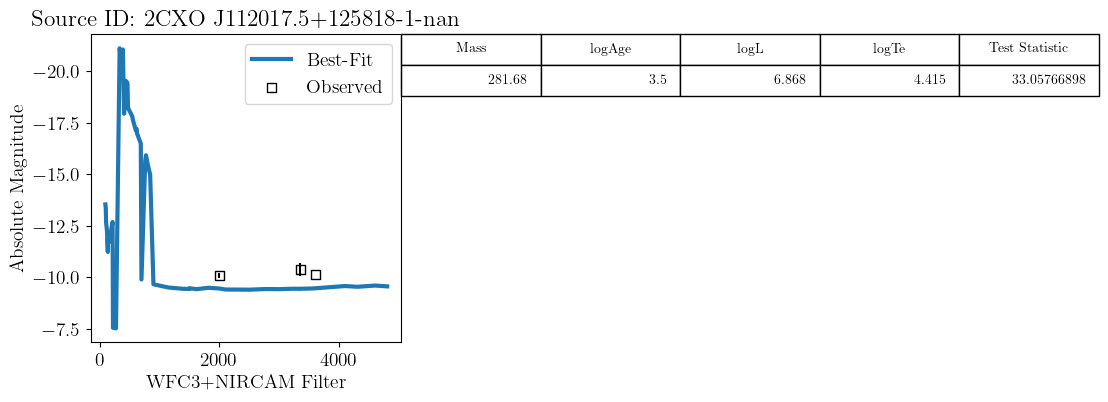

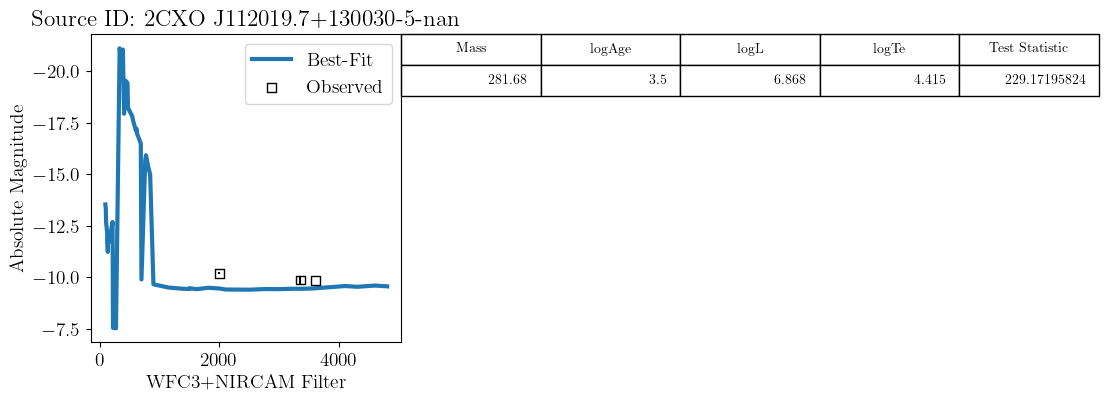

Zini       MH  logAge     Mini  int_IMF    Mass   logL  logTe   logg  \
0   0.0152  0.01508    3.68   40.000     2.63   39.99  5.383  4.244  2.584   
1   0.0152  0.01508    3.50   23.027     2.63   23.03  4.567  3.704  1.001   
2   0.0152  0.01508    3.50   23.231     2.63   23.23  4.590  3.710  1.007   
3   0.0152  0.01508    3.50   25.573     2.63   25.57  4.773  3.785  1.166   
4   0.0152  0.01508    3.62   23.187     2.63   23.19  4.653  3.841  1.468   
..     ...      ...     ...      ...      ...     ...    ...    ...    ...   
85  0.0152  0.01508    3.98   20.579     2.63   20.58  4.517  4.055  2.407   
86  0.0152  0.01508    3.74   30.194     2.63   30.18  5.007  4.137  2.410   
87  0.0152  0.01508    3.50   26.496     2.63   26.48  4.825  3.813  1.240   
88  0.0152  0.01508    3.50   24.067     2.63   24.07  4.670  3.738  1.054   
89  0.0152  0.01508    3.50  350.030     2.63  281.68  6.868  4.415  2.631   

   label  ...  F2500M  F3000M  F3350M  F3600M F4100M  F4300M  F4600M  F4800M  \
0      0  ...  -6.606  -6.587  -6.576  -6.570 -6.562  -6.557  -6.555  -6.549   
1      0  ...  -8.513  -8.634  -8.643  -8.647 -8.651  -8.620  -8.505  -8.521   
2      0  ...  -8.541  -8.644  -8.652  -8.655 -8.660  -8.632  -8.530  -8.545   
3      0  ...  -8.481  -8.502  -8.506  -8.509 -8.517  -8.517  -8.516  -8.515   
4      0  ...  -7.738  -7.757  -7.759  -7.762 -7.771  -7.773  -7.777  -7.775   
..   ...  ...     ...     ...     ...     ...    ...     ...     ...     ...   
85     0  ...  -5.838  -5.835  -5.830  -5.828 -5.827  -5.826  -5.826  -5.821   
86     0  ...  -6.461  -6.452  -6.444  -6.441 -6.437  -6.435  -6.434  -6.429   
87     0  ...  -8.387  -8.406  -8.409  -8.413 -8.421  -8.423  -8.428  -8.425   
88     0  ...  -8.594  -8.638  -8.643  -8.647 -8.652  -8.638  -8.591  -8.599   
89     0  ...  -9.394  -9.420  -9.437  -9.462 -9.571  -9.534  -9.594  -9.555   

    Test Statistic                  Auxiliary ID  
0         0.000721   2CXO J112013.7+130025-2-1.0  
1         0.005304   2CXO J112015.2+125921-3-2.0  
2         0.006030   2CXO J112015.2+125921-3-1.0  
3         0.006341   2CXO J112013.7+130025-4-1.0  
4         0.009358   2CXO J112013.7+130025-5-2.0  
..             ...                           ...  
85      368.614342  2CXO J112019.0+130027-17-3.0  
86      389.178316   2CXO J112015.9+125727-1-2.0  
87      517.079283  2CXO J112019.0+130027-19-6.0  
88     1133.260802   2CXO J112016.8+125959-9-5.0  
89      229.171958   2CXO J112019.7+130030-5-nan  

[90 rows x 82 columns]

In [182]:
best_fit = FitSED(
    df=M66_xrbs,
    instrument='wfc3+nircam',
    idheader='Auxiliary ID',
    plotSED=True
)
display(best_fit)

In [183]:
best_fit.to_csv(M66_dir+"M66_hst-hmxbs_jwst-xrbs_sedfitting.csv")

# Finding the most likely parent cluster

I am going to use the cluster catalog shared with me by Qiana and not the ones available on PHANGS' websites. They are all over the place. 

## Investigate the cluster catalog

In [211]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec
 
clustercat

ID_PHANGS_CLUSTERS  PHANGS_X  PHANGS_Y   PHANGS_RA  PHANGS_DEC  \
0                     14   6614.89   3239.51  170.066136   12.939566   
1                     46   7284.40   3396.34  170.058575   12.941292   
2                     55   6620.99   3457.63  170.066067   12.941966   
3                     68   6698.34   3482.21  170.065193   12.942237   
4                     90   6745.89   3520.91  170.064656   12.942663   
...                  ...       ...       ...         ...         ...   
2707               10668   6508.61  10905.57  170.067338   13.023935   
2708               10670   5445.22  11002.79  170.079350   13.025004   
2709               10671   5461.06  11051.32  170.079171   13.025538   
2710               10672   5442.73  11130.65  170.079378   13.026411   
2711               10673   5495.42  11151.45  170.078783   13.026640   

      PHANGS_CLUSTER_CLASS_HUMAN  PHANGS_CLUSTER_CLASS_ML_VGG  \
0                            1.0                          2.0   
1                            1.0                          1.0   
2                            1.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
2707                         NaN                          1.0   
2708                         NaN                          1.0   
2709                         NaN                          1.0   
2710                         NaN                          2.0   
2711                         NaN                          1.0   

      PHANGS_CLUSTER_CLASS_ML_VGG_QUAL  PHANGS_F275W_VEGA_TOT  \
0                                  0.9              20.644782   
1                                  0.8              24.105332   
2                                  1.0              22.281919   
3                                  1.0              20.826262   
4                                  1.0              22.925218   
...                                ...                    ...   
2707                               1.0                    NaN   
2708                               1.0              24.172877   
2709                               0.9              24.396912   
2710                               0.7                    NaN   
2711                               1.0              23.661047   

      PHANGS_F275W_VEGA_TOT_ERR  ...  PHANGS_EBV_MINCHISQ  \
0                      0.026597  ...                 0.31   
1                      0.370370  ...                 0.15   
2                      0.077378  ...                 0.00   
3                      0.026111  ...                 0.01   
4                      0.134522  ...                 0.00   
...                         ...  ...                  ...   
2707                        NaN  ...                 0.04   
2708                   0.408993  ...                 0.92   
2709                   0.497328  ...                 0.35   
2710                        NaN  ...                 0.08   
2711                   0.269806  ...                 0.38   

      PHANGS_EBV_MINCHISQ_ERR  PHANGS_REDUCED_MINCHISQ  NO_DETECTION_FLAG  \
0                        0.04                 0.155719                0.0   
1                        0.17                 0.675790                0.0   
2                        0.01                 0.798219                0.0   
3                        0.03                 0.181574                0.0   
4                        0.10                 0.702583                0.0   
...                       ...                      ...                ...   
2707                     0.37                 0.141133                2.0   
2708                     0.13                 0.060492                0.0   
2709                     0.24                 0.026141                0.0   
2710                     0.33                 0.046162                1.0   

In [212]:
WriteReg(
    sources=clustercat,
    coordheads=['RA', 'Dec'],
    coordsys='fk5',
    radius=0.3,#clustercat['r_eff(arcsec)'].tolist(),
    radunit='arcsec',
    idheader='ID_PHANGS_CLUSTERS',
    outfile=M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg saved!


## Find distances between XRBs and Clusters

In [272]:
M66_xrbs = remove_unnamed(pd.read_csv(M66_dir+'M66_hmxbs-hst_xrbs-jwst.csv'))
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame'))

In [273]:
temp = M66_best[['CSC ID', 'RA', 'Dec', '2Sig', '2Sig (pix)']]
temp = temp.rename(columns={
    'RA'         : 'CSC RA',
    'Dec'        : 'CSC Dec',
    '2Sig'       : '2 Sig (arcsec)',
    '2Sig (pix)' : '2 Sig (pix)'
})
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')
M66_xrbs

CSC ID          RA        Dec  JWST ID  HST ID  F2000W ID  \
0    2CXO J112014.9+125933  170.062313  12.992598        1     2.0     194701   
1    2CXO J112014.9+125933  170.062307  12.992623        3     2.0     194908   
2    2CXO J112014.9+125933  170.062255  12.992622        4     2.0     194909   
3    2CXO J112015.0+125936  170.062808  12.993437        2     1.0     200852   
4    2CXO J112015.0+125936  170.062752  12.993454        3     1.0     201035   
..                     ...         ...        ...      ...     ...        ...   
102  2CXO J112017.1+130025  170.071459  13.007163        3     NaN     295482   
103  2CXO J112016.4+130034  170.068549  13.009719       22     NaN     308544   
104  2CXO J112018.7+130027  170.078058  13.007556        1     NaN     297652   
105  2CXO J112017.5+125818  170.072952  12.971857        1     NaN      66103   
106  2CXO J112019.7+130030  170.082249  13.008335        5     NaN     301712   

     F3000M ID  F3350M ID  F3600M ID  F275W ID  ...            Y     F300M  \
0      45185.0        NaN        NaN  130956.0  ...          NaN       NaN   
1      45185.0        NaN        NaN  130956.0  ...          NaN       NaN   
2          NaN        NaN        NaN  130956.0  ...          NaN       NaN   
3      46417.0    42593.0    48557.0       NaN  ...          NaN       NaN   
4      46417.0    42593.0        NaN       NaN  ...          NaN       NaN   
..         ...        ...        ...       ...  ...          ...       ...   
102        NaN        NaN        NaN       NaN  ...  7610.007514       NaN   
103        NaN        NaN        NaN       NaN  ...  7909.223941       NaN   
104        NaN        NaN        NaN       NaN  ...  7655.963957       NaN   
105    16342.0    14372.0    17297.0       NaN  ...  3476.508951 -9.589733   
106    68734.0    63775.0    71929.0       NaN  ...  7747.193740 -9.686687   

     F360M Err  Flag  Notes                  Auxiliary ID      CSC RA  \
0          NaN   NaN    NaN   2CXO J112014.9+125933-1-2.0  170.062259   
1          NaN   NaN    NaN   2CXO J112014.9+125933-3-2.0  170.062259   
2          NaN   NaN    NaN   2CXO J112014.9+125933-4-2.0  170.062259   
3          NaN   NaN    NaN   2CXO J112015.0+125936-2-1.0  170.062785   
4          NaN   NaN    NaN   2CXO J112015.0+125936-3-1.0  170.062785   
..         ...   ...    ...                           ...         ...   
102        NaN   NaN    NaN   2CXO J112017.1+130025-3-nan  170.071464   
103        NaN   NaN    NaN  2CXO J112016.4+130034-22-nan  170.068581   
104        NaN   NaN    NaN   2CXO J112018.7+130027-1-nan  170.078060   
105  -0.338285   NaN    NaN   2CXO J112017.5+125818-1-nan  170.072942   
106  -0.154806   NaN    NaN   2CXO J112019.7+130030-5-nan  170.082346   

       CSC Dec  2 Sig (arcsec)  2 Sig (pix)  
0    12.992633        0.235415     5.941826  
1    12.992633        0.235415     5.941826  
2    12.992633        0.235415     5.941826  
3    12.993429        0.243913     6.156299  
4    12.993429        0.243913     6.156299  
..         ...             ...          ...  
102  13.007172        0.425717    10.745008  
103  13.009677        1.077406    27.193498  
104  13.007556        0.253438     6.396718  
105  12.971853        0.246879     6.231177  
106  13.008354        0.747840    18.875313  

[107 rows x 44 columns]

In [274]:
region = M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
catalog = 'Cluster'
search_radius = 1000 / (3600 * 45.4)
distances = calculate_distance(
    df=M66_xrbs,
    regions=region,
    catalogs=catalog,
    imagefilename=f555w,
    search_radius=search_radius,
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    instrument='wfc3',
)
distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


CSC RA    CSC Dec                 CSC ID Cluster ID          RA  \
0     170.062259  12.992633  2CXO J112014.9+125933       6740  170.062313   
1     170.062259  12.992633  2CXO J112014.9+125933       6788  170.062313   
2     170.062259  12.992633  2CXO J112014.9+125933       6969  170.062313   
3     170.062259  12.992633  2CXO J112014.9+125933       7009  170.062313   
4     170.062259  12.992633  2CXO J112014.9+125933       7020  170.062313   
...          ...        ...                    ...        ...         ...   
9602  170.082346  13.008354  2CXO J112019.7+130030      10185  170.082249   
9603  170.082346  13.008354  2CXO J112019.7+130030      10247  170.082249   
9604  170.082346  13.008354  2CXO J112019.7+130030      10280  170.082249   
9605  170.082346  13.008354  2CXO J112019.7+130030      10335  170.082249   
9606  170.082346  13.008354  2CXO J112019.7+130030      10369  170.082249   

            Dec JWST ID HST ID F2000W ID F3000M ID  ... Flag Notes  \
0     12.992598       1    2.0    194701   45185.0  ...  nan   nan   
1     12.992598       1    2.0    194701   45185.0  ...  nan   nan   
2     12.992598       1    2.0    194701   45185.0  ...  nan   nan   
3     12.992598       1    2.0    194701   45185.0  ...  nan   nan   
4     12.992598       1    2.0    194701   45185.0  ...  nan   nan   
...         ...     ...    ...       ...       ...  ...  ...   ...   
9602  13.008335       5    nan    301712   68734.0  ...  nan   nan   
9603  13.008335       5    nan    301712   68734.0  ...  nan   nan   
9604  13.008335       5    nan    301712   68734.0  ...  nan   nan   
9605  13.008335       5    nan    301712   68734.0  ...  nan   nan   
9606  13.008335       5    nan    301712   68734.0  ...  nan   nan   

                     Auxiliary ID 2 Sig (arcsec) 2 Sig (pix)  Cluster RA  \
0     2CXO J112014.9+125933-1-2.0       0.235415    5.941826  170.061849   
1     2CXO J112014.9+125933-1-2.0       0.235415    5.941826  170.061836   
2     2CXO J112014.9+125933-1-2.0       0.235415    5.941826  170.058290   
3     2CXO J112014.9+125933-1-2.0       0.235415    5.941826  170.057680   
4     2CXO J112014.9+125933-1-2.0       0.235415    5.941826  170.058557   
...                           ...            ...         ...         ...   
9602  2CXO J112019.7+130030-5-nan        0.74784   18.875313  170.080968   
9603  2CXO J112019.7+130030-5-nan        0.74784   18.875313  170.082492   
9604  2CXO J112019.7+130030-5-nan        0.74784   18.875313  170.079838   
9605  2CXO J112019.7+130030-5-nan        0.74784   18.875313  170.079447   
9606  2CXO J112019.7+130030-5-nan        0.74784   18.875313  170.081020   

     Cluster Dec Cluster Separation (arcsecs) Cluster Separation (pc)  \
0      12.987713                    17.662335              803.636229   
1      12.987976                    16.724924              760.984055   
2      12.988918                    19.356667              880.728353   
3      12.989119                    20.516221              933.488043   
4      12.989210                    17.954213              816.916676   
...          ...                          ...                     ...   
9602   13.010411                     8.722325              396.865785   
9603   13.011024                     9.719769              442.249510   
9604   13.011564                    14.377491              654.175830   
9605   13.012467                    17.829221              811.229570   
9606   13.013110                    17.726181              806.541213   

     Cluster Separation (km)  
0               2.479762e+16  
1               2.348151e+16  
2               2.717644e+16  
3               2.880443e+16  
4               2.520741e+16  
...                      ...  
9602            1.224600e+16  
9603            1.364639e+16  
9604            2.018576e+16  
9605            2.503193e+16  
9606            2.488726e+16  

[9607 rows x 50 columns]

In [275]:
# add the cluster masses, ages and info to the main dataframe
temp = clustercat[[
    'ID_PHANGS_CLUSTERS',
    'PHANGS_CI', 
    'PHANGS_AGE_MINCHISQ',
    'PHANGS_AGE_MINCHISQ_ERR', 
    'PHANGS_MASS_MINCHISQ',
    'PHANGS_MASS_MINCHISQ_ERR', 
    'PHANGS_EBV_MINCHISQ',
    'PHANGS_EBV_MINCHISQ_ERR', 
    'PHANGS_REDUCED_MINCHISQ',
    'fwhm', 'r_eff(pix)', 
    'r_eff(arcsec)', 'r_eff(pc)'
]] 
temp = temp.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)'
})
distances = distances.merge(temp, on='Cluster ID', how='left')
distances

CSC RA    CSC Dec                 CSC ID Cluster ID          RA  \
0     170.062259  12.992633  2CXO J112014.9+125933       6740  170.062313   
1     170.062259  12.992633  2CXO J112014.9+125933       6788  170.062313   
2     170.062259  12.992633  2CXO J112014.9+125933       6969  170.062313   
3     170.062259  12.992633  2CXO J112014.9+125933       7009  170.062313   
4     170.062259  12.992633  2CXO J112014.9+125933       7020  170.062313   
...          ...        ...                    ...        ...         ...   
9602  170.082346  13.008354  2CXO J112019.7+130030      10185  170.082249   
9603  170.082346  13.008354  2CXO J112019.7+130030      10247  170.082249   
9604  170.082346  13.008354  2CXO J112019.7+130030      10280  170.082249   
9605  170.082346  13.008354  2CXO J112019.7+130030      10335  170.082249   
9606  170.082346  13.008354  2CXO J112019.7+130030      10369  170.082249   

            Dec JWST ID HST ID F2000W ID F3000M ID  ... Cluster Age Err (Myr)  \
0     12.992598       1    2.0    194701   45185.0  ...                 153.0   
1     12.992598       1    2.0    194701   45185.0  ...                 120.0   
2     12.992598       1    2.0    194701   45185.0  ...                  77.0   
3     12.992598       1    2.0    194701   45185.0  ...                  48.0   
4     12.992598       1    2.0    194701   45185.0  ...                  34.0   
...         ...     ...    ...       ...       ...  ...                   ...   
9602  13.008335       5    nan    301712   68734.0  ...                 304.0   
9603  13.008335       5    nan    301712   68734.0  ...                 601.0   
9604  13.008335       5    nan    301712   68734.0  ...                  47.0   
9605  13.008335       5    nan    301712   68734.0  ...                 257.0   
9606  13.008335       5    nan    301712   68734.0  ...                  23.0   

     Cluster Mass (M_sun) Cluster Mass Err (M_sun) Cluster EBV  \
0            32159.451166             67739.414328        0.80   
1           174363.656114             17070.864641        0.00   
2            69972.213290             11389.178992        0.10   
3           206060.938059             14694.145980        0.01   
4            43030.350062               573.446002        0.26   
...                   ...                      ...         ...   
9602         12481.192604              2034.672635        0.00   
9603         16733.055418               840.994966        0.00   
9604         16653.964282             12270.683907        0.44   
9605         27366.891900             15388.605638        0.48   
9606         32026.633444               692.282813        0.48   

     Cluster EBV Err Cluster Test Statistic Cluster FWHM  \
0               0.50              23.386633         0.96   
1               0.01               3.086535         0.39   
2               0.09               1.464285         1.91   
3               0.09               0.208602         1.91   
4               0.07               0.680461         2.36   
...              ...                    ...          ...   
9602            0.26               0.619071         1.32   
9603            0.34               0.345233         1.55   
9604            0.22               0.848338         1.55   
9605            0.00               0.107967         2.87   
9606            0.08               0.424279         0.96   

     Cluster Radius Eff (pix) Cluster Radius Eff (arcsec)  \
0                      1.4208                    0.056832   
1                      0.5772                    0.023088   
2                      2.8268                    0.113072   
3                      2.8268                    0.113072   
4                      3.4928                    0.139712   
...                       ...                         ...   
9602                   1.9536                    0.078144   
9603                   2.2940                    0.091760   
9604                   2.2940                    

In [276]:
# Incorporate ages and masses of the stars
best_fit = remove_unnamed(pd.read_csv(M66_dir+"M66_hst-hmxbs_jwst-xrbs_sedfitting.csv"))
best_fit = best_fit[['logAge', 'Mass', 'Auxiliary ID']]

logAge = best_fit['logAge'].values
age = np.exp(1) ** logAge * u.Myr
age_s = age.to(u.second)

best_fit['Star Age (s)'] = age_s
best_fit['Star Age (Myr)'] = age
best_fit['Star Mass (M_sun)'] = best_fit['Mass']

temp = best_fit[['Auxiliary ID', 'Star Mass (M_sun)', 'Star Age (s)', 'Star Age (Myr)']]
distances = distances.merge(temp, on='Auxiliary ID', how='left')
distances

CSC RA    CSC Dec                 CSC ID Cluster ID          RA  \
0     170.062259  12.992633  2CXO J112014.9+125933       6740  170.062313   
1     170.062259  12.992633  2CXO J112014.9+125933       6788  170.062313   
2     170.062259  12.992633  2CXO J112014.9+125933       6969  170.062313   
3     170.062259  12.992633  2CXO J112014.9+125933       7009  170.062313   
4     170.062259  12.992633  2CXO J112014.9+125933       7020  170.062313   
...          ...        ...                    ...        ...         ...   
9602  170.082346  13.008354  2CXO J112019.7+130030      10185  170.082249   
9603  170.082346  13.008354  2CXO J112019.7+130030      10247  170.082249   
9604  170.082346  13.008354  2CXO J112019.7+130030      10280  170.082249   
9605  170.082346  13.008354  2CXO J112019.7+130030      10335  170.082249   
9606  170.082346  13.008354  2CXO J112019.7+130030      10369  170.082249   

            Dec JWST ID HST ID F2000W ID F3000M ID  ... Cluster EBV  \
0     12.992598       1    2.0    194701   45185.0  ...        0.80   
1     12.992598       1    2.0    194701   45185.0  ...        0.00   
2     12.992598       1    2.0    194701   45185.0  ...        0.10   
3     12.992598       1    2.0    194701   45185.0  ...        0.01   
4     12.992598       1    2.0    194701   45185.0  ...        0.26   
...         ...     ...    ...       ...       ...  ...         ...   
9602  13.008335       5    nan    301712   68734.0  ...        0.00   
9603  13.008335       5    nan    301712   68734.0  ...        0.00   
9604  13.008335       5    nan    301712   68734.0  ...        0.44   
9605  13.008335       5    nan    301712   68734.0  ...        0.48   
9606  13.008335       5    nan    301712   68734.0  ...        0.48   

     Cluster EBV Err Cluster Test Statistic Cluster FWHM  \
0               0.50              23.386633         0.96   
1               0.01               3.086535         0.39   
2               0.09               1.464285         1.91   
3               0.09               0.208602         1.91   
4               0.07               0.680461         2.36   
...              ...                    ...          ...   
9602            0.26               0.619071         1.32   
9603            0.34               0.345233         1.55   
9604            0.22               0.848338         1.55   
9605            0.00               0.107967         2.87   
9606            0.08               0.424279         0.96   

     Cluster Radius Eff (pix) Cluster Radius Eff (arcsec)  \
0                      1.4208                    0.056832   
1                      0.5772                    0.023088   
2                      2.8268                    0.113072   
3                      2.8268                    0.113072   
4                      3.4928                    0.139712   
...                       ...                         ...   
9602                   1.9536                    0.078144   
9603                   2.2940                    0.091760   
9604                   2.2940                    0.091760   
9605                   4.2476                    0.169904   
9606                   1.4208                    0.056832   

     Cluster Radius Eff (pc) Star Mass (M_sun)  Star Age (s) Star Age (Myr)  
0                   3.113757            292.88  1.045044e+15      33.115452  
1                   1.264964            292.88  1.045044e+15      33.115452  
2                   6.195079            292.88  1.045044e+15      33.115452  
3                   6.195079            292.88  1.045044e+15      33.115452  
4                   7.654653            292.88  1.045044e+15      33.115452  
...                      ...               ...           ...            ...  
9602                4.281416            281.68  1.045044e+15      33.115452  
9603                5.027420            281.68  1.045044e+15      33.115452  
9604                5.027420            281.68  1.045044e+15      33.115452 

In [365]:
clusters = distances[[
    'CSC ID','Class', 'Auxiliary ID', 'JWST ID', 'HST ID',
    'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)',
    'Cluster Mass (M_sun)', 'Star Mass (M_sun)',
    'Cluster Separation (arcsecs)', 'Cluster Separation (pc)',
    'Cluster Separation (km)'
]]

clusters

CSC ID Class                 Auxiliary ID JWST ID HST ID  \
0     2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1-2.0       1    2.0   
1     2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1-2.0       1    2.0   
2     2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1-2.0       1    2.0   
3     2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1-2.0       1    2.0   
4     2CXO J112014.9+125933  HMXB  2CXO J112014.9+125933-1-2.0       1    2.0   
...                     ...   ...                          ...     ...    ...   
9602  2CXO J112019.7+130030  LMXB  2CXO J112019.7+130030-5-nan       5    nan   
9603  2CXO J112019.7+130030  LMXB  2CXO J112019.7+130030-5-nan       5    nan   
9604  2CXO J112019.7+130030  LMXB  2CXO J112019.7+130030-5-nan       5    nan   
9605  2CXO J112019.7+130030  LMXB  2CXO J112019.7+130030-5-nan       5    nan   
9606  2CXO J112019.7+130030  LMXB  2CXO J112019.7+130030-5-nan       5    nan   

     Cluster ID  Star Age (Myr)  Cluster Age (Myr)  Cluster Mass (M_sun)  \
0          6740       33.115452                5.0          32159.451166   
1          6788       33.115452              890.0         174363.656114   
2          6969       33.115452              500.0          69972.213290   
3          7009       33.115452              158.0         206060.938059   
4          7020       33.115452              110.0          43030.350062   
...         ...             ...                ...                   ...   
9602      10185       33.115452              500.0          12481.192604   
9603      10247       33.115452              770.0          16733.055418   
9604      10280       33.115452               53.0          16653.964282   
9605      10335       33.115452              243.0          27366.891900   
9606      10369       33.115452               53.0          32026.633444   

      Star Mass (M_sun)  Cluster Separation (arcsecs)  \
0                292.88                     17.662335   
1                292.88                     16.724924   
2                292.88                     19.356667   
3                292.88                     20.516221   
4                292.88                     17.954213   
...                 ...                           ...   
9602             281.68                      8.722325   
9603             281.68                      9.719769   
9604             281.68                     14.377491   
9605             281.68                     17.829221   
9606             281.68                     17.726181   

      Cluster Separation (pc)  Cluster Separation (km)  
0                  803.636229             2.479762e+16  
1                  760.984055             2.348151e+16  
2                  880.728353             2.717644e+16  
3                  933.488043             2.880443e+16  
4                  816.916676             2.520741e+16  
...                       ...                      ...  
9602               396.865785             1.224600e+16  
9603               442.249510             1.364639e+16  
9604               654.175830             2.018576e+16  
9605               811.229570             2.503193e+16  
9606               806.541213             2.488726e+16  

[9607 rows x 13 columns]

In [281]:
M66_best

Separation                  CSC ID          RA        Dec  \
0     0.603512   2CXO J112014.9+125929  170.062428  12.991495   
1     1.154310   2CXO J112015.0+125928  170.062878  12.991329   
2     4.249587   2CXO J112014.9+125933  170.062259  12.992633   
3     4.484088  2CXO J112015.2+125932X  170.063665  12.992189   
4     5.940189   2CXO J112015.3+125932  170.064119  12.992230   
..         ...                     ...         ...        ...   
83  231.679093   2CXO J112030.5+130013  170.127457  13.003663   
84  237.496980   2CXO J112008.5+130307  170.035399  13.051914   
85  240.218881   2CXO J112019.6+130320  170.081736  13.055570   
86  246.797558   2CXO J112027.8+125649  170.116113  12.946999   
87  249.864798   2CXO J112025.4+130247  170.106001  13.046538   

    Err Ellipse Major  Err Ellipse Minor  Err Ellipse Angle  Significance  \
0            0.311932           0.311917           0.000000      9.567092   
1            0.317501           0.317501           0.000000      7.701153   
2            0.299684           0.298357           5.587902     12.795398   
3            3.446421           3.446421           0.000000     39.744111   
4            0.413187           0.343140          64.093176      5.142857   
..                ...                ...                ...           ...   
83           1.402157           0.820192           1.489236      3.575758   
84           0.774353           0.647498         139.851620      4.000000   
85           0.563631           0.427724         157.623228     10.427182   
86           1.754478           1.143646          33.705932      3.294118   
87           1.073411           0.672588         169.752370      4.324324   

   Likelihood conf_flag  ... Counts hilim      1Sig      2Sig           X  \
0        TRUE      True  ...   191.109641  0.115174  0.238746  3732.25780   
1        TRUE      True  ...   142.201784  0.118283  0.248443  3692.38100   
2        TRUE     False  ...   244.566017  0.113925  0.235415  3747.18600   
3        TRUE       NaN  ...  3427.710381  1.725878  3.451755  3622.72450   
4        TRUE     False  ...    46.639197  0.154105  0.345133  3582.56790   
..        ...       ...  ...          ...       ...       ...         ...   
83       TRUE     False  ...    23.316527  0.439176  1.071654 -2024.96930   
84       TRUE     False  ...    30.526982  0.423189  1.022475  6124.79330   
85       TRUE     False  ...   164.908744  0.194439  0.404728  2023.27800   
86       TRUE     False  ...    22.727118  0.436688  1.067144 -1021.79190   
87       TRUE     False  ...    34.482532  0.415924  1.000030  -124.71402   

             Y  2Sig (pix)      ID  Bounds      LogLx  (SNR)  
0    5731.0323    6.025886  CXO001      In  38.449069      0  
1    5715.9783    6.270647  CXO002      In  38.442754      0  
2    5834.4389    5.941826  CXO003      In  38.566181      0  
3    5794.0764   87.121537  CXO004      In        NaN      0  
4    5797.8225    8.711076  CXO005      In  37.911504      0  
..         ...         ...     ...     ...        ...    ...  
83   6837.4179   27.048301  CXO084     Out  37.571116      0  
84  11221.0620   25.807047  CXO085     Out  37.855388      0  
85  11553.1970   10.215239  CXO086     Out  38.690923      0  
86   1688.5554   26.934484  CXO087     Out  37.533265      0  
87  10732.8440   25.240534  CXO088     Out  37.729994      0  

[88 rows x 38 columns]

In [282]:
M66_notes['Parent Cluster ID'] = ''
M66_notes['Parent Cluster Age (Myr)'] = ''
M66_notes['Parent Cluster Mass (M_sun)'] = ''
M66_notes = M66_notes[['ID', 'Class', 'Best Star', 'Cluster ID', 'Mass', 'Notes',
                       'CSC ID', 'Parent Cluster ID', 'Parent Cluster Age (Myr)',
                       'Parent Cluster Mass (M_sun)']]
temp = M66_best[['RA', 'Dec', 'CSC ID']]
M66_notes = M66_notes.merge(temp, on='CSC ID', how='left')
M66_notes.to_csv(M66_dir + "M66_quantifying_xrb_ejection_notes.csv")

In [349]:
from XRBID.WriteScript import WriteReg
temp = distances.copy()
temp['ID'] = distances['Cluster ID'].values.astype(str) + "ID -" + distances['Cluster Age (Myr)'].values.astype(int).astype(str) + 'Myr'
display(temp)
WriteReg(
    sources=temp,
    outfile='/Users/undergradstudent/Downloads/cluster_ages.reg',
    coordsys='fk5',
    coordheads=['Cluster RA', 'Cluster Dec'],
    # additional_coords=['Cluster RA', 'Cluster Dec'],
    # reg_type='ruler',
    idheader='ID',
    radius=0.2,
    radunit='arcsec'
)

CSC RA    CSC Dec                 CSC ID Cluster ID          RA  \
0     170.062259  12.992633  2CXO J112014.9+125933       6740  170.062313   
1     170.062259  12.992633  2CXO J112014.9+125933       6788  170.062313   
2     170.062259  12.992633  2CXO J112014.9+125933       6969  170.062313   
3     170.062259  12.992633  2CXO J112014.9+125933       7009  170.062313   
4     170.062259  12.992633  2CXO J112014.9+125933       7020  170.062313   
...          ...        ...                    ...        ...         ...   
9602  170.082346  13.008354  2CXO J112019.7+130030      10185  170.082249   
9603  170.082346  13.008354  2CXO J112019.7+130030      10247  170.082249   
9604  170.082346  13.008354  2CXO J112019.7+130030      10280  170.082249   
9605  170.082346  13.008354  2CXO J112019.7+130030      10335  170.082249   
9606  170.082346  13.008354  2CXO J112019.7+130030      10369  170.082249   

            Dec JWST ID HST ID F2000W ID F3000M ID  ... Cluster EBV Err  \
0     12.992598       1    2.0    194701   45185.0  ...            0.50   
1     12.992598       1    2.0    194701   45185.0  ...            0.01   
2     12.992598       1    2.0    194701   45185.0  ...            0.09   
3     12.992598       1    2.0    194701   45185.0  ...            0.09   
4     12.992598       1    2.0    194701   45185.0  ...            0.07   
...         ...     ...    ...       ...       ...  ...             ...   
9602  13.008335       5    nan    301712   68734.0  ...            0.26   
9603  13.008335       5    nan    301712   68734.0  ...            0.34   
9604  13.008335       5    nan    301712   68734.0  ...            0.22   
9605  13.008335       5    nan    301712   68734.0  ...            0.00   
9606  13.008335       5    nan    301712   68734.0  ...            0.08   

     Cluster Test Statistic Cluster FWHM Cluster Radius Eff (pix)  \
0                 23.386633         0.96                   1.4208   
1                  3.086535         0.39                   0.5772   
2                  1.464285         1.91                   2.8268   
3                  0.208602         1.91                   2.8268   
4                  0.680461         2.36                   3.4928   
...                     ...          ...                      ...   
9602               0.619071         1.32                   1.9536   
9603               0.345233         1.55                   2.2940   
9604               0.848338         1.55                   2.2940   
9605               0.107967         2.87                   4.2476   
9606               0.424279         0.96                   1.4208   

     Cluster Radius Eff (arcsec) Cluster Radius Eff (pc) Star Mass (M_sun)  \
0                       0.056832                3.113757            292.88   
1                       0.023088                1.264964            292.88   
2                       0.113072                6.195079            292.88   
3                       0.113072                6.195079            292.88   
4                       0.139712                7.654653            292.88   
...                          ...                     ...               ...   
9602                    0.078144                4.281416            281.68   
9603                    0.091760                5.027420            281.68   
9604                    0.091760                5.027420            281.68   
9605                    0.169904                9.308836            281.68   
9606                    0.056832                3.113757            281.68   

      Star Age (s) Star Age (Myr)               ID  
0     1.045044e+15      33.115452     6740ID -5Myr  
1     1.045044e+15      33.115452   6788ID -890Myr  
2     1.045044e+15      33.115452   6969ID -500Myr  
3     1.045044e+15      33.115452   7009ID -158Myr  
4     1.045044e+15      33.115452   7020ID -110Myr  
...            ...            ...              ...  
9602  1.045044e+15      33.115452  10185ID -500

Saving /Users/undergradstudent/Downloads/cluster_ages.reg
/Users/undergradstudent/Downloads/cluster_ages.reg saved!


{np.float64(33.115451958692304)}

In [384]:
cscid =  M66_notes['CSC ID'].values[6] # at 4
# cscid = "2CXO J112019.0+130027"
print(f'###########   {cscid}    #########')
temp = clusters.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True)
age = np.mean(temp['Star Age (Myr)'].values)
# age = set(temp['Star Age (Myr)'].values)
print(f'Age: {age} Myr')
lowmass, highmass = age - (1/2 * age), age + (1/2 * age)
dist = temp['Cluster Separation (pc)'].values
print(f'Minimum Distance: {min(dist)} pc')
print(f'Using lowmass = {lowmass} Myr, highmass = {highmass} Myr')
display(temp)
clusters.query(f'`CSC ID` == "{cscid}" and {highmass} >= `Cluster Age (Myr)` >= {lowmass}')

###########   2CXO J112015.2+125921    #########
Age: 33.1154519586923 Myr
Minimum Distance: 292.40391581931027 pc
Using lowmass = 16.55772597934615 Myr, highmass = 49.67317793803845 Myr


CSC ID Class                  Auxiliary ID JWST ID HST ID  \
0    2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3    1.0   
1    2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3    1.0   
2    2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3    1.0   
3    2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3    1.0   
4    2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3    1.0   
..                     ...   ...                           ...     ...    ...   
553  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11    3.0   
554  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11    3.0   
555  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11    3.0   
556  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11    3.0   
557  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11    3.0   

    Cluster ID  Star Age (Myr)  Cluster Age (Myr)  Cluster Mass (M_sun)  \
0         5844       33.115452              136.0          35710.739566   
1         5993       33.115452                7.0           3694.411302   
2         6033       33.115452                1.0         223008.764860   
3         6096       33.115452               53.0          30043.442945   
4         6147       33.115452               88.0          24224.924767   
..         ...             ...                ...                   ...   
553       7628       33.115452              537.0          20663.643855   
554       7638       33.115452                5.0            916.633257   
555       7677       33.115452              717.0          24538.416279   
556       7811       33.115452              403.0          80643.026407   
557       7842       33.115452                2.0          78259.450334   

     Star Mass (M_sun)  Cluster Separation (arcsecs)  Cluster Separation (pc)  \
0                23.23                     21.391976               973.334889   
1                23.23                     20.609642               937.738722   
2                23.23                     18.950868               862.264501   
3                23.23                     19.516631               888.006717   
4                23.23                     19.910926               905.947141   
..                 ...                           ...                      ...   
553             292.88                     21.048416               957.702916   
554             292.88                     16.184523               736.395781   
555             292.88                     20.467648               931.277989   
556             292.88                     17.796891               809.758539   
557             292.88                     20.954024               953.408104   

     Cluster Separation (km)  
0               3.003398e+16  
1               2.893559e+16  
2               2.660670e+16  
3               2.740102e+16  
4               2.795461e+16  
..                       ...  
553             2.955162e+16  
554             2.272280e+16  
555             2.873624e+16  
556             2.498654e+16  
557             2.941910e+16  

[558 rows x 13 columns]

CSC ID Class                  Auxiliary ID JWST ID  \
584   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
585   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
597   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
609   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
610   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
656   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
657   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-1.0       3   
677   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
678   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
690   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
702   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
703   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
749   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
750   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-3-2.0       3   
770   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
771   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
783   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
795   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
796   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
842   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
843   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-7-3.0       7   
863   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
864   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
876   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
888   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
889   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
935   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
936   2CXO J112015.2+125921  HMXB   2CXO J112015.2+125921-8-3.0       8   
956   2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
957   2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
969   2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
981   2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
982   2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
1028  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
1029  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-10-3.0      10   
1049  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1050  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1062  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1074  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1075  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1121  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   
1122  2CXO J112015.2+125921  HMXB  2CXO J112015.2+125921-11-3.0      11   

     HST ID Cluster ID  Star Age (Myr)  Cluster Age (Myr)  \
584     1.0       6154       33.115452               40.0   
585     1.0       6255       33.115452               46.0   
597     1.0       6734       33.115452               43.0   
609     1.0       7240       33.115452               30.0   
610     1.0       7258       33.115452               26.0   
656     1.0       6953       33.115452               43.0   
657     1.0       7005       33.115452               34.0   
677     2.0       6154       33.115452               40.0   
678     2.0       6255       33.115452               46.0   
690     2.0       6734       33.115452               43.0   
702     2.0       7240       33.115452               30.0   
703     2.0       7258       33.115452               26.0   
74

In [ ]:
distances.to_csv('/Users/undergradstudent/Downloads/finding_parent_clusters.txt')

## Algorithm for finding the parent cluster

In [423]:
best_fit['Star Age (Myr)'].values.value[89], best_fit['Star Age (Myr)'].values.value[82]

(np.float64(33.115451958692304), np.float64(33.115451958692304))

In [443]:
best_fit['Star Age (Myr)'] = best_fit['Star Age (Myr)'].values.value
best_fit

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [448]:
set(best_fit['Star Age (Myr)'])

{33.115451958692304,
 33.78442846384955,
 35.16319714510661,
 37.33756782205365,
 38.09183672539901,
 38.86134287133246,
 39.64639407257259,
 42.0979901649969,
 43.816041735573954,
 50.40044477806547,
 53.51703422749115}

In [450]:
from collections import Counter

mylist = best_fit['Star Age (Myr)']
counts = Counter(mylist)
counts

Counter({33.115451958692304: 71,
         33.78442846384955: 4,
         42.0979901649969: 4,
         37.33756782205365: 2,
         38.86134287133246: 2,
         53.51703422749115: 2,
         39.64639407257259: 1,
         50.40044477806547: 1,
         38.09183672539901: 1,
         35.16319714510661: 1,
         43.816041735573954: 1})

In [ ]:
index=1
best_fit['Star']

In [459]:
anotherlist = []
for index, row in best_fit.iterrows():
    if best_fit['Star Age (Myr)'][index] ==  33.115451958692304:
        anotherlist.append(best_fit['Auxiliary ID'][index])

anotherlist.sort()
anotherlist

['2CXO J112011.8+125811-5-1.0',
 '2CXO J112012.6+125947-4-nan',
 '2CXO J112012.8+125947-2-1.0',
 '2CXO J112012.8+125947-4-1.0',
 '2CXO J112013.0+125736-4-1.0',
 '2CXO J112013.5+125944-4-1.0',
 '2CXO J112013.5+125944-4-2.0',
 '2CXO J112013.5+125944-6-1.0',
 '2CXO J112013.5+125944-6-2.0',
 '2CXO J112013.7+130025-1-1.0',
 '2CXO J112013.7+130025-11-4.0',
 '2CXO J112013.7+130025-16-4.0',
 '2CXO J112013.7+130025-18-5.0',
 '2CXO J112013.7+130025-19-6.0',
 '2CXO J112013.7+130025-22-6.0',
 '2CXO J112013.7+130025-23-6.0',
 '2CXO J112013.7+130025-4-1.0',
 '2CXO J112013.7+130025-6-2.0',
 '2CXO J112013.7+130025-8-3.0',
 '2CXO J112014.3+125918-9-nan',
 '2CXO J112014.7+125937-12-2.0',
 '2CXO J112014.7+125937-12-3.0',
 '2CXO J112014.7+125937-13-2.0',
 '2CXO J112014.7+125937-13-3.0',
 '2CXO J112014.7+125937-14-4.0',
 '2CXO J112014.7+125937-15-4.0',
 '2CXO J112014.7+125937-18-4.0',
 '2CXO J112014.7+125937-4-1.0',
 '2CXO J112014.7+125937-6-1.0',
 '2CXO J112014.7+125937-6-2.0',
 '2CXO J112014.7+125937-6-3

In [ ]:
for cscid in best_fit['Star Age (Myr)']

In [391]:
def find_parent_cluster(df):
    df = df.copy()

    for cscid in df['CSC ID'].values:
        print(f'################## {cscid} ###################')
        star_age = df['Star Age (Myr)']
        print(star_age)

    return star_age

x = find_parent_cluster(distances)

################## 2CXO J112014.9+125933 ###################
0       33.115452
1       33.115452
2       33.115452
3       33.115452
4       33.115452
          ...    
9602    33.115452
9603    33.115452
9604    33.115452
9605    33.115452
9606    33.115452
Name: Star Age (Myr), Length: 9607, dtype: float64
################## 2CXO J112014.9+125933 ###################
0       33.115452
1       33.115452
2       33.115452
3       33.115452
4       33.115452
          ...    
9602    33.115452
9603    33.115452
9604    33.115452
9605    33.115452
9606    33.115452
Name: Star Age (Myr), Length: 9607, dtype: float64
################## 2CXO J112014.9+125933 ###################
0       33.115452
1       33.115452
2       33.115452
3       33.115452
4       33.115452
          ...    
9602    33.115452
9603    33.115452
9604    33.115452
9605    33.115452
9606    33.115452
Name: Star Age (Myr), Length: 9607, dtype: float64
################## 2CXO J112014.9+125933 ###################
0       3